IMPORTS

In [65]:
# CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import os                         # OS-level utilities (path handling, directory checks, file management)
# VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools
# STEP 3) DECOMPOSING
from statsmodels.tsa.seasonal import seasonal_decompose         # Decompose time-series into trend, seasonal, and residual components
from statsmodels.tsa.stattools import acf                       # Compute autocorrelation values
# STEP 4) STATIONARITY ANALYSIS
from statsmodels.tsa.stattools import adfuller                  # Dickey-Fuller test for stationarity evaluation
# STEP 5) RESIDUALS DIAGNOSTICS
from statsmodels.stats.diagnostic import acorr_ljungbox         # Ljung-Box test for checking autocorrelation in residuals
# STEP 6) ACF/PACF DIAGNOSTICS + ORDER GRIDS
from statsmodels.tsa.stattools import pacf                      # Compute partial autocorrelation values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # Plot ACF & PACF with confidence bands

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

HELPER FUNCTIONS

In [ ]:
# ===============================
# Log printer
# ===============================
def log(
    message: str,
    icon: str = "INFO",
    level: int = 1,
    bold: bool = False
):
    # Icon dictionary (semantic → emoji)
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
        "SUGGESTION": "💡"
    }

    # If icon matches a key → use mapped emoji
    # Else → assume user passed a custom emoji/string
    final_icon = icons.get(icon.upper(), icon)
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # Prefix by level
    if level == 1:
        prefix = "•"
    elif level == 2:
        prefix = "   -"
    elif level == 3:
        prefix = "      ·"
    else:
        prefix = "-"
    # Print
    print(f"{prefix} {final_icon} {message}")

# ===============================
# Get revision number - Returns the next free integer revision based on existing files
# ===============================
def get_revision_number(base_path, base_name):
    rev = 0
    while True:
        full_path = os.path.join(base_path, base_name + "_" + str(rev) + ".csv")
        if not os.path.exists(full_path):
            return rev
        rev += 1

# ===============================
# Determines granularity given seconds
# ===============================
def determine_granularity(seconds: float) -> str:
    # Use tolerance windows (robust)
    if 3500 <= seconds <= 3700:
        return "1-hour"
    if 3.5*3600 <= seconds <= 4.5*3600:
        return "4-hour"
    if 23*3600 <= seconds <= 25*3600:
        return "1-day"
    return "other"

# ===============================
# Map granularity to pandas frequency alias
# ===============================
def get_pandas_freq_from_granularity(granularity: str) -> str | None:
    if granularity=="1-hour":
        return "h"
    if granularity=="4-hour":
        return "4h"
    if granularity=="1-day":
        return "D"
    return None

# ===============================
# Pick a safe max lag for ACF/PACF based on granularity + seasonal period
# ===============================
def get_safe_lag_for_acf_pacf(granularity: str, period_m: int, n: int, max_cap: int = 300) -> int:
    base_candidates=lag_candidates_from_granularity(granularity)  # base lags from granularity
    nice=[l for l in base_candidates if l>=2]  # keep only meaningful lags
    if period_m is not None and period_m>1:  # add seasonal period multiples if valid
        nice=nice+[period_m,2*period_m,3*period_m]  # enrich candidates with seasonality
    nice=sorted(list(set(nice)))  # deduplicate and sort candidates
    target=max(nice) if nice else 50  # choose highest candidate or default
    safe=min(target,max_cap,n-2)  # cap by user max and sample size
    return max(10,safe)  # enforce minimum lag floor

# ===============================
# Candidate seasonal periods by granularity (time steps)
# ===============================
def period_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        # Daily, weekly, bi-weekly, monthly (~30d), bi-monthly (~60d)
        return [24, 168, 336, 720, 1440]
    if granularity == "4-hour":
        # Daily (6), weekly (42), bi-weekly (84), monthly (~30d -> 180)
        return [6, 42, 84, 180]
    if granularity == "1-day":
        # Weekly, bi-weekly, monthly (~30d), quarterly (~90d)
        return [7, 14, 30, 90]
    return []

# ===============================
# Returns an integer period (m) to use in decomposition / SARIMA.
#- If manual_period is provided -> use it.
# - Else -> try ACF among plausible candidates.
# - Else -> fallback to the first plausible candidate.
# If there are no candidates, raises ValueError.
# ===============================
def decide_seasonal_period(
    timeseries: pd.Series,
    granularity: str,
    manual_period: int | None = None
):
    candidates = period_candidates_from_granularity(granularity)
    if not candidates:
        raise ValueError(f"No valid period candidates for granularity='{granularity}'")
    # 1) Manual override
    log(f"1st) Trying to infer period from manual input:", level=2)
    if manual_period is not None:
        return manual_period, "MANUAL PERIOD"
    else:
        log(f"No manual input was indicated for seasonal period", icon="WARNING", level=3)
    # 2) ACF among candidates
    #m_acf = infer_period_from_acf_candidates(timeseries, candidates, threshold=acf_threshold)
    m_acf=infer_period_from_acf_candidates(timeseries,candidates,debug=True)
    if m_acf is not None:
        return m_acf, "ACF PERIOD"
    # 3) Fallback: first candidate (daily if available, else weekly)
    log(f"3rd) Fallback to infer period as first candidate based on granularity", level=2)
    return candidates[0], "FIRST CANDIDATE PERIOD"

# ===============================
# Infer seasonal period from ACF values among candidate lags
# ===============================
def infer_period_from_acf_candidates(
    series: pd.Series,
    candidates: list[int],
    threshold: float = 0.02,
    max_lag_cap: int = 2000,
    debug: bool = True
) -> int | None:
    x = pd.Series(series).dropna().astype(float)
    if debug:
        log(f"2nd) Trying to infer period from acf (n={len(x)} | candidates={candidates} | threshold={threshold}):", level=2)
    x = x.diff().dropna()
    if debug:
        log(f"After differentiation: n={len(x)}", level=3)

    if x.empty or not candidates:
        if debug:
            log("After differentiation: empty series or no candidates -> return None", icon="WARNING", level=3)
        return None
    # Dynamic threshold based on sample size
    dyn_threshold = 1.96 / np.sqrt(len(x))
    thr_used = max(threshold, dyn_threshold)
    if debug:
        log(f"Dynamic threshold= {dyn_threshold:.4f} | Using threshold={thr_used:.4f}", level=3)

    max_lag = min(max(max(candidates) * 2, 50), max_lag_cap)
    if debug:
        log(f"Lags: max_lag={max_lag} (cap={max_lag_cap})", level=3)
    if len(x) < max_lag + 5:
        if debug:
            log(f"Not enough samples for nlags={max_lag} -> need >= {max_lag+5}, have {len(x)} -> return None", icon="WARNING", level=3)
        return None
    ac = acf(x, nlags=max_lag, fft=True, missing="drop")
    best_m = None
    best_val = -np.inf
    for m in candidates:
        if m <= max_lag:
            val = float(ac[m])
            if debug:
                log(f"ACF at lag m={m}: {val:.4f}", icon="INFO", level=3)
            if val > best_val:
                best_val = val
                best_m = m
    if debug:
        log(f"Best candidate: m={best_m} -> acf={best_val:.4f}", level=3)
    if best_m is not None and best_val >= thr_used:
        if debug:
            log(f"ACCEPT period inference from acf m={best_m} (acf={best_val:.4f} >= {thr_used:.4f})", icon="SUCCESS", level=3, bold=True)
        return best_m
    if debug:
        log(f"REJECT period inference from acf (best acf={best_val:.4f} < {thr_used:.4f}) -> return None", icon="WARNING", level=3)
    return None

# ===============================
# Generate returns for crypto time-series
# ===============================
def generate_returns(
    price_series: pd.Series, # Time-indexed price series (e.g. close).
    method: str = "log",      # "log" or "diff" -> log returns (recommended for crypto)
    clip_outliers: bool = True, #Whether to clip extreme returns (robustness)
    clip_quantile: float = 0.01 # Quantile for clipping (0.01 -> clip 1% tails)
) -> pd.Series:
    s = price_series.astype(float).copy()
    if method == "log":
        # Avoid log(0)
        s = s.replace(0, np.nan)
        returns = np.log(s).diff()
    elif method == "diff":
        returns = s.diff()
    else:
        raise ValueError("Method must be 'log' or 'diff'")
    returns = returns.dropna()
    # Optional: clip extreme tails (important for crypto spikes)
    if clip_outliers and len(returns) > 50:
        lower = returns.quantile(clip_quantile)
        upper = returns.quantile(1 - clip_quantile)
        returns = returns.clip(lower, upper)
    return returns
    
# ===============================
# Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
# ===============================
def assess_seasonality_strength(
    original: pd.Series,
    seasonal: pd.Series,
    period: int,
    acf_threshold: float,
    var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# ===============================
# Residual diagnostics on returns:
# A) Trend check (slope ~ 0)
# B) Periodicity via ACF (no strong peaks)
# C) Centering (mean ~ 0)
# D) Randomness via Ljung-Box (p > 0.05)
# ===============================
def run_residual_diagnostics(residual_ret: pd.Series, label: str):
    residual_ret = residual_ret.dropna().astype(float)
    if len(residual_ret) < 50:
        log(f"{label}: Not enough residual points (n<50). Skipping.", icon="WARNING", level=2)
        return

    # RULE A: trend in residuals
    x_index = np.arange(len(residual_ret))
    slope, intercept = np.polyfit(x_index, residual_ret.values, 1)
    residual_std = np.std(residual_ret.values)
    if residual_std < 1e-8:
        log(f"{label}: Residuals almost constant -> no visible trend (good)", icon="SUCCESS", level=2)
    else:
        if abs(slope) < max(residual_std * 0.01, 1e-6):
            log(f"{label}: No visible trend (slope={slope:.3e}) (good)", icon="SUCCESS", level=2)
        else:
            log(f"{label}: Trend detected (slope={slope:.3e}) (bad)", icon="WARNING", level=2)

    # RULE B: periodicity via ACF
    if residual_std < 1e-8:
        log(f"{label}: Residuals almost constant -> no periodicity (good)", icon="SUCCESS", level=2)
    else:
        nlags = min(max(10, 2 * period), min(80, len(residual_ret) - 2))
        if nlags < 5:
            log(f"{label}: Not enough points for ACF", icon="WARNING", level=2)
        else:
            acf_res = acf(residual_ret, nlags=nlags, fft=True, missing="drop")
            acf_res_no0 = acf_res[1:]
            max_acf_lag = np.argmax(np.abs(acf_res_no0)) + 1
            max_acf_value = acf_res[max_acf_lag]
            log(f"{label}: Residual ACF strongest lag={max_acf_lag}, value={max_acf_value:.3f}", level=2)
            if np.isnan(max_acf_value):
                log(f"{label}: ACF not reliable -> assume no periodicity (good)", icon="SUCCESS", level=2)
            elif abs(max_acf_value) < 0.3:
                log(f"{label}: No meaningful periodicity (good)", icon="SUCCESS", level=2)
            else:
                log(f"{label}: Periodicity detected (bad)", icon="WARNING", level=2)

    # RULE C: center
    residual_center = 0.0
    mean_res = residual_ret.mean()
    sd_res = residual_ret.std()
    threshold_center = max(sd_res * 0.05, 1e-6)
    if abs(mean_res - residual_center) < threshold_center:
        log(f"{label}: Centered around 0 (mean={mean_res:.3e}) (good)", icon="SUCCESS", level=2)
    else:
        log(f"{label}: Not well centered (mean={mean_res:.3e}) (bad)", icon="WARNING", level=2)

    # RULE D: randomness (Ljung-Box)
    residual_centered = residual_ret - residual_center
    sd_centered = residual_centered.std()
    if sd_centered < 1e-8:
        log(f"{label}: Residuals almost constant -> assume random (good)", icon="SUCCESS", level=2)
    else:
        test_lags = lag_candidates_from_granularity(granularity)
        test_lags = [l for l in test_lags if 2 <= l < len(residual_centered) - 2]
        if not test_lags:
            log(f"{label}: No valid lags for Ljung-Box", icon="WARNING", level=2)
        else:
            lb_df = acorr_ljungbox(residual_centered, lags=test_lags, return_df=True)
            for L in test_lags:
                pval = float(lb_df.loc[L, "lb_pvalue"])
                log(f"{label}: Ljung-Box p-value (lag {L})={pval:.4f}", level=2)
            if (lb_df["lb_pvalue"] > 0.05).all():
                log(f"{label}: Residuals behave like white noise (good)", icon="SUCCESS", level=2)
            else:
                log(f"{label}: Residuals show autocorrelation (bad)", icon="WARNING", level=2)

            lb_abs = acorr_ljungbox(np.abs(residual_centered), lags=test_lags, return_df=True)
            if (lb_abs["lb_pvalue"] <= 0.05).any():
                log(f"{label}: Volatility effect detected (ARCH/GARCH-like)", icon="WARNING", bold=True, level=2)

# ===============================
# Performs Dickey-Fuller test to determine if a series is stacionary or not
# ===============================
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# ===============================
# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
# ===============================
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

# ===============================
# Returns meaningful Ljung–Box / ACF lags (expressed in number of time steps) based on time granularity
# ===============================
def lag_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        return [
            2,      # 2h (short-term micro autocorrelation)
            6,      # 6h
            24,     # 1 day
            48,     # 2 days
            168     # 1 week
        ]
    if granularity == "4-hour":
        return [
            2,      # 8h (very short-term)
            3,      # 12h
            6,      # 1 day
            12,     # 2 days
            42      # 1 week
        ]
    if granularity == "1-day":
        return [
            2,      # 2 days
            7,      # 1 week
            14,     # 2 weeks
            30      # ~1 month
        ]
    return []

def prepare_diag_series(series: pd.Series, d_order: int, label: str):
    base = series.dropna().astype(float).copy()
    diag = base.copy()
    if d_order > 0:
        diag = diag.diff(d_order).dropna()
    log(f"{label} diagnostics prepared with d={d_order} (n={len(diag)})", icon="INFO", level=2)
    return base, diag

# -------------------------------
# METRICS HELPERS
# -------------------------------
# MAE (Mean Absolute Error)
def mae(y_true: pd.Series, y_pred: pd.Series) -> float:
    return float(np.mean(np.abs(y_true.values - y_pred.values)))
# RMSE (Root Mean Squared Error)
def rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    return float(np.sqrt(np.mean((y_true.values - y_pred.values) ** 2)))
#  MASE (Mean Absolute Scaled Error)
def mase(y_true: pd.Series, y_pred: pd.Series, y_train: pd.Series) -> float:
    y_train = y_train.dropna().astype(float)
    if len(y_train) < 2:
        return np.nan
    naive_in_sample = np.abs(y_train.diff().dropna()).mean()
    if naive_in_sample == 0:
        return np.nan
    return float(np.mean(np.abs(y_true.values - y_pred.values)) / naive_in_sample)
# sMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true: pd.Series, y_pred: pd.Series) -> float:
    y_t = y_true.values.astype(float)
    y_p = y_pred.values.astype(float)
    num = np.abs(y_p - y_t)
    den = (np.abs(y_t) + np.abs(y_p))
    mask = den != 0
    if mask.sum() == 0:
        return np.nan
    return float(100 * np.mean(2 * num[mask] / den[mask]))


def eval_split_naive(y_train: pd.Series, y_test: pd.Series, label: str):
    naive_pred = y_test.shift(1)
    if len(y_train) > 0 and len(naive_pred) > 0:
        naive_pred.iloc[0] = y_train.iloc[-1]

    y_true = y_test.copy()
    y_pred = naive_pred.copy()
    mask = y_true.notna() & y_pred.notna()
    y_true = y_true.loc[mask]
    y_pred = y_pred.loc[mask]

    if len(y_true) < 10:
        log(f"{label}: not enough points to evaluate naive baseline", icon="WARNING", level=2)
        return None

    return {
        "mae": mae(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "mase": mase(y_true, y_pred, y_train),
        "smape": smape(y_true, y_pred),
        "y_true": y_true,
        "y_pred": y_pred
    }

def rolling_eval_naive(series: pd.Series, label: str, collect_rows: list | None = None):
    do_rolling_eval = True
    rolling_folds = 3
    min_train_ratio = 0.6

    if do_rolling_eval and len(series) >= 200:
        n = len(series)
        min_train = int(n * min_train_ratio)
        if min_train + 20 >= n:
            log(f"{label}: not enough data for rolling eval after min_train", icon="WARNING", level=2)
        else:
            fold_size = (n - min_train) // (rolling_folds + 1)
            if fold_size < 10:
                log(f"{label}: fold size too small", icon="WARNING", level=2)
            else:
                for i in range(rolling_folds):
                    train_end = min_train + i * fold_size
                    test_end = min(train_end + fold_size, n)
                    y_train = series.iloc[:train_end].copy()
                    y_test = series.iloc[train_end:test_end].copy()
                    if len(y_test) < 10:
                        continue

                    y_pred = y_test.shift(1)
                    if len(y_train) > 0 and len(y_pred) > 0:
                        y_pred.iloc[0] = y_train.iloc[-1]

                    y_t, y_p = y_test.align(y_pred, join="inner")
                    mask = y_t.notna() & y_p.notna()
                    y_t = y_t.loc[mask]
                    y_p = y_p.loc[mask]
                    if len(y_t) < 10:
                        continue

                    m = {
                        "mae": mae(y_t, y_p),
                        "rmse": rmse(y_t, y_p),
                        "mase": mase(y_t, y_p, y_train),
                        "smape": smape(y_t, y_p)
                    }
                    if collect_rows is not None:
                        collect_rows.append(m)

                    log(
                        f"{label} | Fold {i+1}/{rolling_folds} | train_end={y_train.index.max()} | test_end={y_test.index.max()} "
                        f"-> MAE={m['mae']:.6f} RMSE={m['rmse']:.6f} MASE={m['mase']:.6f} SMAPE={m['smape']:.2f}%",
                        icon="INFO",
                        level=2
                    )
    else:
        log(f"{label}: rolling eval skipped (not enough data or disabled)", icon="WARNING", level=2)

# -------------------------------
# Data-driven thresholds
# -------------------------------
def rel_diff(a, b):
    if b == 0 or b is None or np.isnan(b):
        return np.nan
    return abs(a - b) / abs(b)

# -------------------------------
# Adequacy checks
# -------------------------------
def check_stability(main_m, second_m, thresh):
    if main_m is None or second_m is None:
        return "insufficient"
    diffs = [
        rel_diff(second_m["mae"], main_m["mae"]),
        rel_diff(second_m["rmse"], main_m["rmse"]),
        rel_diff(second_m["mase"], main_m["mase"])
    ]
    if any(np.isnan(d) for d in diffs):
        return "insufficient"
    return "ok" if all(d <= thresh for d in diffs) else "unstable"

def check_expanding(fold_rows, cv_thresh):
    if not fold_rows or len(fold_rows) < 2:
        return "insufficient"
    maes = np.array([r["mae"] for r in fold_rows], dtype=float)
    rmses = np.array([r["rmse"] for r in fold_rows], dtype=float)
    if maes.mean() == 0 or rmses.mean() == 0:
        return "insufficient"
    mae_cv = maes.std() / maes.mean()
    rmse_cv = rmses.std() / rmses.mean()
    return "ok" if (mae_cv <= cv_thresh and rmse_cv <= cv_thresh) else "unstable"

INPUTS

In [43]:
# ===============================
# INPUTS: HALVING REGIMES
# ===============================
# Exact Bitcoin halving dates (YYYY-MM-DD) used for regime windows
#halving_dates = ["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-20"]
halving_dates = ["2016-07-09", "2020-05-11", "2024-04-20"]
# ===============================
# STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES
# ===============================
raw_data_separator = ";"    # CSV separator for the raw file
raw_data_input_path = "../data/raw/raw_price_dowloaded_1h_START_10-01-2015_END_18-01-2026.csv"  # Path to raw input CSV
time_column = "time"        # Datetime column name used as primary time axis
target_column = "close"     # Target variable to model as time-series
day_comes_first = True      # Date parsing order: day/month/year

# ===============================
# STEP 2) SEASONALITY / DECOMPOSITION
# ===============================
seasonal_period = None                  # Manual seasonal period m; None -> auto inference

# ===============================
# STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)
# ===============================
accepted_alpha_dickey_fuller = 0.05     # ADF alpha threshold to accept stationarity

# ===============================
# STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS
# ===============================
test_size = 0.2                         # Fraction of data reserved for test split

# ===============================
# STEPS 5-6) OUTPUT FILES
# ===============================
processed_data_output_path = "../data/processed/"  # Output folder for saved datasets/metrics

# ===============================
# STEPS 1, 5, 6) PLOTTING
# ===============================
figHeight_unit = 8          # Base figure height
figWidth_unit = 12          # Base figure width
plot_tick_font_size = 15    # Tick label font size
plot_label_font_size = 15   # Axis label font size
plot_title_font_size = 20   # Plot title font size


STEP 1) EXPLORE DATAFRAME

STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES
• 1. LOAD RAW DATAFRAME
   - ℹ️ Shape of the raw DataFrame: (96625, 5)
   - ℹ️ Preview of the raw DataFrame:


,time,open,max,min,close
0,10/01/2015 0:00,293.89,295.00,289.10,289.22
1,10/01/2015 1:00,289.20,291.49,286.00,289.18
2,10/01/2015 2:00,289.18,289.18,286.01,287.00
3,10/01/2015 3:00,286.66,288.38,286.65,288.38
4,10/01/2015 4:00,288.38,292.88,288.04,290.24




• 2. EXPLORE DATAFRAME
   - 📈 Numeric metrics detected: Index(['open', 'max', 'min', 'close'], dtype='object')
   - ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
open,96625.0,27849.481088,31981.399509,171.61,3714.2,11418.4,43126.0,126073.3
max,96625.0,27954.381162,32075.432212,174.17,3739.9,11476.0,43288.5,126198.1
min,96625.0,27737.904409,31882.487103,1.50,3692.0,11368.1,42979.0,125350.0
close,96625.0,27850.330589,31981.813192,171.41,3715.0,11416.3,43132.1,126073.3




• 3. TIME INDEX INFORMATION
   - 📅 Detected time column: 'time'
   - 📅 Rows removed due to invalid timestamps (NaT): 0
   - 📅 Start date: 2015-01-10 00:00:00
   - 📅 End date: 2026-01-18 00:00:00
   - 📅 Total duration: 4026 days 00:00:00
   - ✅ No negative diffs detected
   - ✅ No duplicated timestamps detected


• 4. ESTIMATE FREQUENCY AND GRANULARITY
   - 📅 Most common interval: 0 days 01:00:00 (3600.0 secs) -> granularity: 1-hour
   - 📅 Smallest interval: 0 days 01:00:00 (3600.0 secs)
   - 📅 Frequency consistency ratio: 1.00000000


• 5. BUILD TIMESERIES + HALVING-REGIME WINDOWS
   - ℹ️ Indexed DataFrame by 'time'
   - ℹ️ Preview of time-indexed DataFrame:


,time,open,max,min,close
time,,,,,
2015-01-10 00:00:00,10/01/2015 0:00,293.89,295.00,289.10,289.22
2015-01-10 01:00:00,10/01/2015 1:00,289.20,291.49,286.00,289.18
2015-01-10 02:00:00,10/01/2015 2:00,289.18,289.18,286.01,287.00
2015-01-10 03:00:00,10/01/2015 3:00,286.66,288.38,286.65,288.38
2015-01-10 04:00:00,10/01/2015 4:00,288.38,292.88,288.04,290.24


   - ℹ️ Target column detected: 'close'
   - ✅ None NaN values found in target 'close'
   - ✅ Target column 'close' (96625 rows) has been successfully extracted as time-series:
time
2015-01-10 00:00:00    289.22
2015-01-10 01:00:00    289.18
2015-01-10 02:00:00    287.00
2015-01-10 03:00:00    288.38
2015-01-10 04:00:00    290.24


• 6. PLOT TIMESERIES WITH HALVING-REGIME WINDOWS


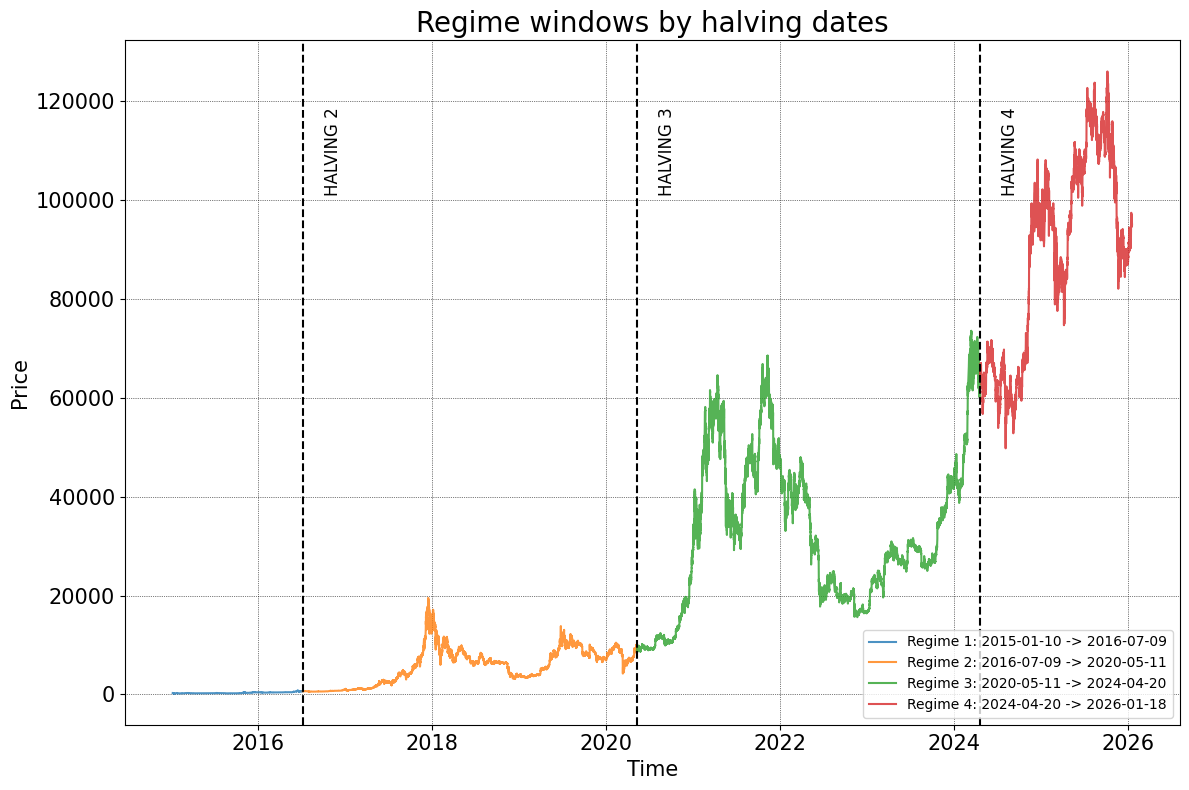

In [44]:
print("===============================")
print("STEP 1) EXPLORE DATAFRAME AND BUILD TIMESERIES")
print("===============================")

# -------------------------------
# 1. LOAD RAW DATAFRAME
# -------------------------------
log(f"LOAD RAW DATAFRAME", icon="1.", bold=True)
# Load dataframe
df_raw = pd.read_csv(raw_data_input_path, sep=raw_data_separator)
# Print raw df info
log(f"Shape of the raw DataFrame: {df_raw.shape}", level=2)
log("Preview of the raw DataFrame:", level=2)
display(df_raw.head(5))
print("\n")

# -------------------------------
# 2. EXPLORE DATAFRAME
# -------------------------------
log(f"EXPLORE DATAFRAME", icon="2.", bold=True)
# Previous data
df = df_raw.copy()
# Get time series
serie_time = pd.to_datetime(df[time_column], errors="coerce", dayfirst=day_comes_first) #'coerce': then invalid parsing will be set as NaT
# Keep only rows with valid timestamps (avoid NaT contaminating checks)
valid_mask=serie_time.notna()
df=df.loc[valid_mask].copy()
serie_time=serie_time.loc[valid_mask].copy()
# Sort by time before diff/frequency checks
order_idx=serie_time.sort_values().index
df=df.loc[order_idx].copy()
serie_time=serie_time.loc[order_idx].copy()
# Find if any time goes backwards
serie_time_diff = serie_time.diff().dropna()
bad_idx = serie_time_diff[serie_time_diff < pd.Timedelta(0)].index
# Find if any duplicated timestamps
dup_count = serie_time.duplicated().sum()
dup_times=serie_time[serie_time.duplicated(keep=False)]
# Numeric metrics
numeric_cols = df.select_dtypes(include=["number"]).columns
log(f"Numeric metrics detected: {numeric_cols}", icon="📈", level=2)
# Statistics for each metric
log("Basic statistics per numeric variable:", level=2)
display(df[numeric_cols].describe().T)
print("\n")

# -------------------------------
# 3. TIME INDEX INFORMATION
# -------------------------------
log("TIME INDEX INFORMATION", icon="3.", bold=True)
log(f"Detected time column: '{time_column}'", icon="📅", level=2)
log(f"Rows removed due to invalid timestamps (NaT): {len(df_raw)-len(df)}", icon="📅", level=2)
log(f"Start date: {serie_time.min()}", icon="📅", level=2)
log(f"End date: {serie_time.max()}", icon="📅", level=2)
log(f"Total duration: {serie_time.max() - serie_time.min()}", icon="📅", level=2)
if len(bad_idx) >0:
    log(f"Number of negative diffs: {len(bad_idx)}", icon="ERROR", level=2)
    log(f"Example indices: {bad_idx[:10].tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Negative time differences found")
else:
    log("No negative diffs detected", icon="SUCCESS", level=2)
if dup_count>0:
    log(f"Number of duplicated timestamps: {dup_count}", icon="ERROR", level=2)
    log(f"Duplicated timestamps sample: {dup_times.head(10).tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Duplicated timestamps found")
else:
    log("No duplicated timestamps detected", icon="SUCCESS", level=2)
print("\n")

# -------------------------------
# 4. ESTIMATE FREQUENCY AND GRANULARITY
# -------------------------------
log(f"ESTIMATE FREQUENCY AND GRANULARITY", icon="4.", bold=True)
if len(serie_time_diff) > 0:
    df_most_common_delta = serie_time_diff.mode()[0] # Most common interval
    # Detect potential missing timestamps (gaps larger than the expected interval)
    expected_delta = df_most_common_delta
    gap_mask = serie_time_diff > expected_delta
    gap_count = gap_mask.sum()
    if gap_count > 0:
        log(f"Potential missing data detected: {gap_count} gaps > expected interval {expected_delta}", icon="WARNING", level=2)

        # Show exact timestamps (previous time -> current time)
        gap_idx = serie_time_diff[gap_mask].index[:5]
        for idx in gap_idx:
            t_prev = serie_time.loc[idx - 1] if (idx - 1) in serie_time.index else None
            t_curr = serie_time.loc[idx]
            log(f"Gap: {t_prev} -> {t_curr} (delta={serie_time_diff.loc[idx]})", icon="WARNING", level=3)


    df_smallest_delta = serie_time_diff.min() # Minimal interval
    df_freq_ratio = (serie_time_diff == df_most_common_delta).mean()
    if df_freq_ratio < 0.7:
        raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_freq_ratio:.3f})")
    # Determine granularity
    granularity = determine_granularity(df_most_common_delta.total_seconds())
    if granularity=="other":
        log(f"Granularity not recognized from seconds={df_most_common_delta.total_seconds()} -> period inference may fail",level=2,type="WARNING")
    log(f"Most common interval: {df_most_common_delta} ({df_most_common_delta.total_seconds()} secs) -> granularity: {granularity}", icon="📅", level=2, bold=True)
    log(f"Smallest interval: {df_smallest_delta} ({df_smallest_delta.total_seconds()} secs)", icon="📅", level=2, bold=True)
    log(f"Frequency consistency ratio: {df_freq_ratio:.8f}", icon="📅", level=2, bold=True)
else:
    log("Not enough data points to estimate frequency nor granurality", icon="ERROR", level=2)
    raise ValueError(f"Not enough data points")
# Missing or irregular timestamps
if len(serie_time_diff) > 0:
    missing_ratio = 1 - df_freq_ratio
else:
    missing_ratio = None
if missing_ratio is not None and missing_ratio > 0.10:
    log("Irregular timestamps detected (missing or uneven intervals)", level=2, type="WARNING")
    log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")
print("\n")

# -------------------------------
# 5. BUILD TIMESERIES + HALVING-REGIME WINDOWS
# -------------------------------
log(f"BUILD TIMESERIES + HALVING-REGIME WINDOWS", icon="5.", bold=True)
# Assign the datetime index
df.index=pd.DatetimeIndex(serie_time)
# Make sure the index has a name
df.index.name=time_column
if not df.index.is_monotonic_increasing:
    raise ValueError("Datetime index is not sorted")
if df.index.duplicated().any():
    raise ValueError("Datetime index has duplicates")
log(f"Indexed DataFrame by '{time_column}'", level=2)
# Show preview
log("Preview of time-indexed DataFrame:", level=2)
display(df.head(5))
log(f"Target column detected: '{target_column}'", level=2)
nan_target=df[target_column].isna().sum()
if nan_target>0:
    log(f"NaN values found in target '{target_column}': {nan_target} -> rows will be dropped for modeling", icon="WARNING", level=2)
else:
    log(f"None NaN values found in target '{target_column}'", icon="SUCCESS", level=2)
# Extract target timeseries
timeseries=df[target_column].dropna().astype(float)
log(f"Target column '{target_column}' ({len(timeseries)} rows) has been successfully extracted as time-series:", icon="SUCCESS", level=2)
print(timeseries[:5].to_string(dtype=False))
# Sort and convert to datetime halvings
try:
    hv_dates = pd.to_datetime(halving_dates, errors="coerce").dropna().sort_values()
except Exception as e:
    hv_dates = pd.to_datetime([], errors="coerce")
    log(f"Could not parse halving dates -> {e}", icon="WARNING", level=2)
# Build regime edges from data range + halving dates inside range
start_ts = timeseries.index.min()
end_ts = timeseries.index.max()
hv_in_range = []
for hv_date in hv_dates:
    if start_ts < hv_date < end_ts:
        hv_in_range.append(hv_date)
edges = [start_ts] + hv_in_range + [end_ts]
print("\n")

# -------------------------------
# 6. PLOT TIMESERIES WITH HALVING-REGIME WINDOWS
# -------------------------------
log("PLOT TIMESERIES WITH HALVING-REGIME WINDOWS", icon="6.", bold=True)

# Start plot
if len(edges) < 2:
    log("No valid halving boundaries inside data range -> skip timeseries with halvings plot.", icon="WARNING", level=2)
else:
    fig, ax = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    for i in range(len(edges) - 1):
        seg = timeseries.loc[edges[i]:edges[i + 1]]
        label = f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}"
        if len(seg) > 0:
            ax.plot(seg.index, seg.values, label=label, alpha=0.8)
    # Mark halving dates + labels
    y_top = timeseries.max()*0.8
    for i, hv_date in enumerate(hv_in_range, start=1):
        ax.axvline(x=hv_date, color="black", linewidth=1.5, linestyle="--")
        ax.text(
            hv_date, y_top,
            f"\nHALVING {i+1}",
            rotation=90,
            va="bottom",
            ha="left",
            fontsize=plot_label_font_size*0.8,
            color="black"
        )
    # Settings of the plot
    ax.set_title("Regime windows by halving dates", fontsize=plot_title_font_size)
    ax.set_xlabel("Time", fontsize=plot_label_font_size)
    ax.set_ylabel("Price", fontsize=plot_label_font_size)
    ax.tick_params(labelsize=plot_tick_font_size)
    ax.legend()
    ax.grid(True, linestyle="dotted", linewidth=0.5, color="black")
    plt.tight_layout()
    plt.show()

STEP 2) DECOMPOSE TIME-SERIES

STEP 2) DECOMPOSE TIME-SERIES
• 1. AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m)
   - ℹ️ 1st) Trying to infer period from manual input:
      · ⚠️ No manual input was indicated for seasonal period
   - ℹ️ 2nd) Trying to infer period from acf (n=96625 | candidates=[24, 168, 336, 720, 1440] | threshold=0.02):
      · ℹ️ After differentiation: n=96624
      · ℹ️ Dynamic threshold= 0.0063 | Using threshold=0.0200
      · ℹ️ Lags: max_lag=2000 (cap=2000)
      · ℹ️ ACF at lag m=24: -0.0215
      · ℹ️ ACF at lag m=168: 0.0024
      · ℹ️ ACF at lag m=336: -0.0031
      · ℹ️ ACF at lag m=720: 0.0013
      · ℹ️ ACF at lag m=1440: 0.0040
      · ℹ️ Best candidate: m=1440 -> acf=0.0040
      · ⚠️ REJECT period inference from acf (best acf=0.0040 < 0.0200) -> return None
   - ℹ️ 3rd) Fallback to infer period as first candidate based on granularity
   - ✅ -> Selected seasonal period (m)=24 for '1-hour' granularity


• 2. GLOBAL SEASONALITY (ON RETURNS) (LOG-DIFF)
   - 💡 WEAK SEASONALITY detected f

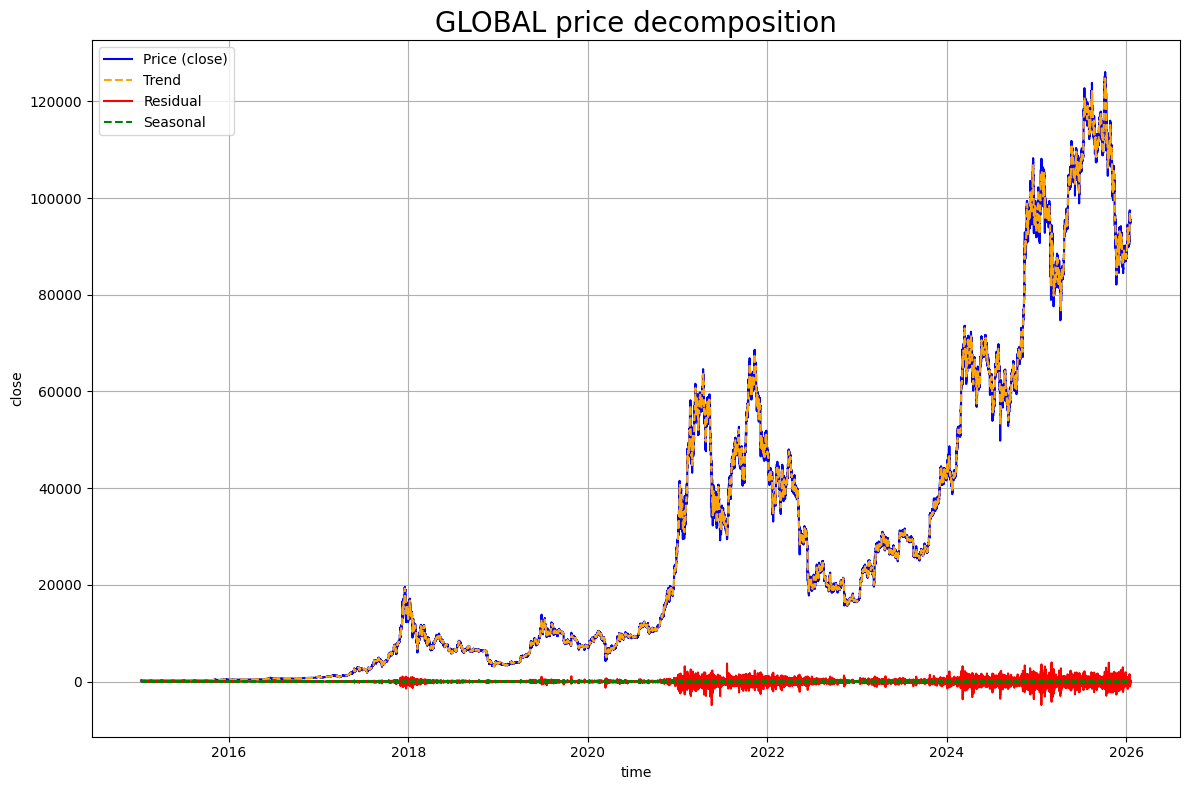



• 6.2. PRICE DECOMPOSITION (PER-REGIME)
   - ✅ Regime 1 price decomposition completed successfully


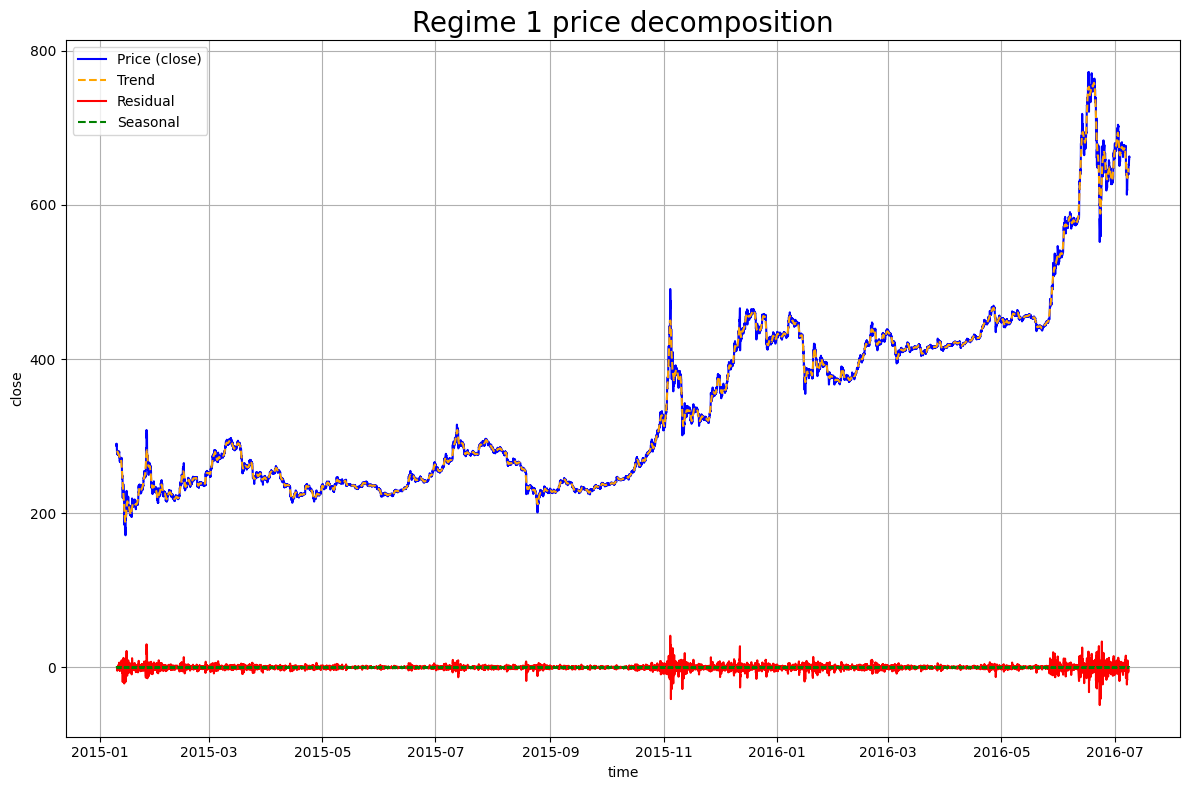

   - ✅ Regime 2 price decomposition completed successfully


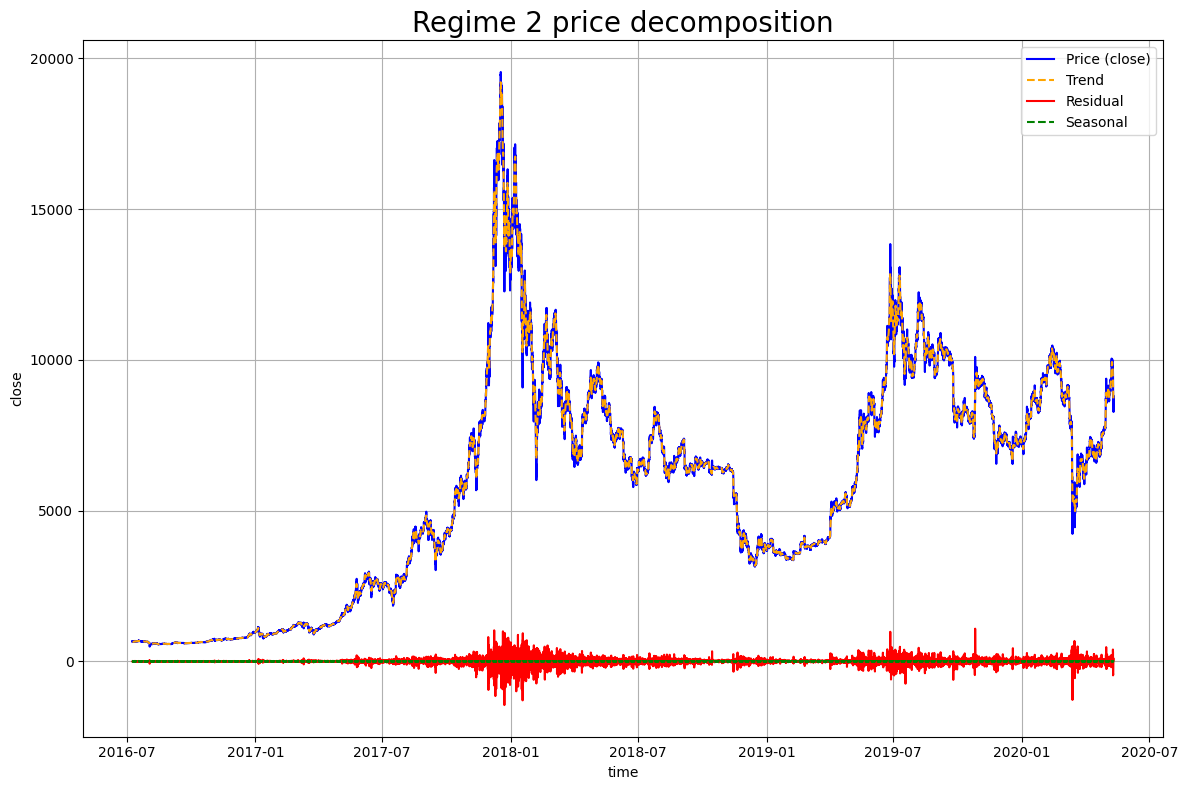

   - ✅ Regime 3 price decomposition completed successfully


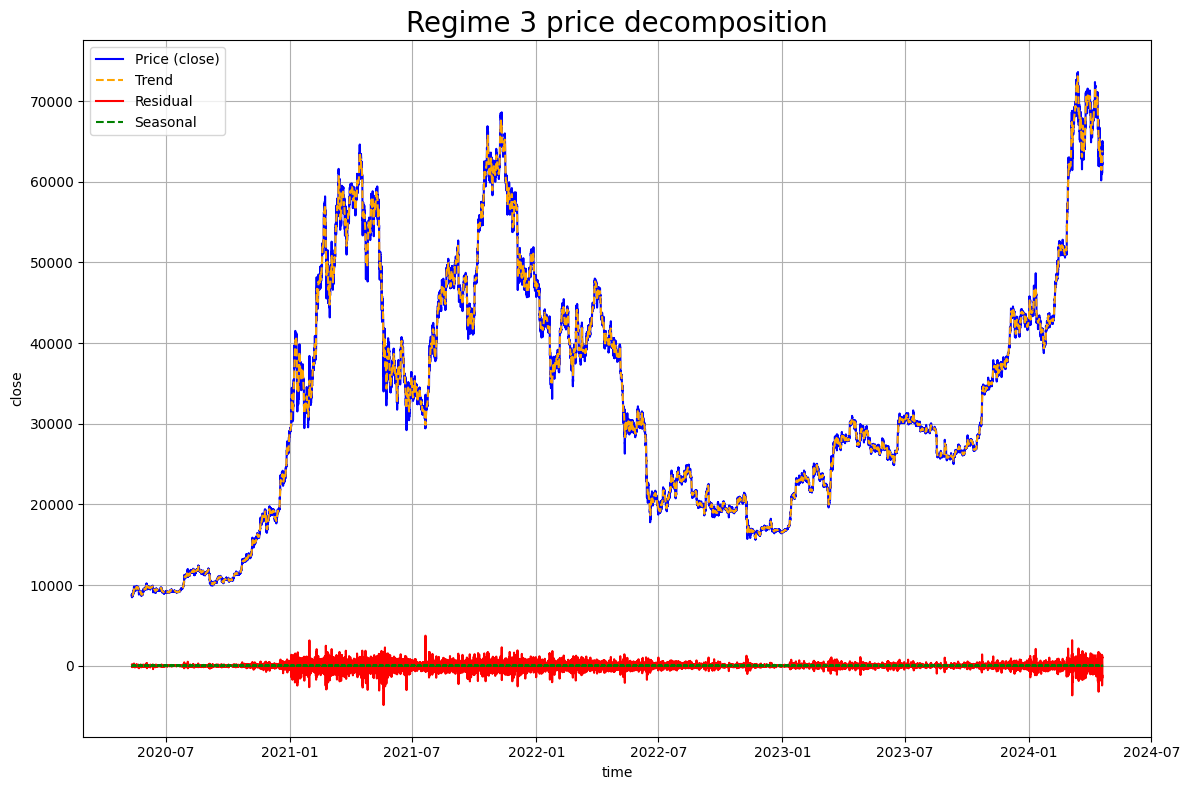

   - ✅ Regime 4 price decomposition completed successfully


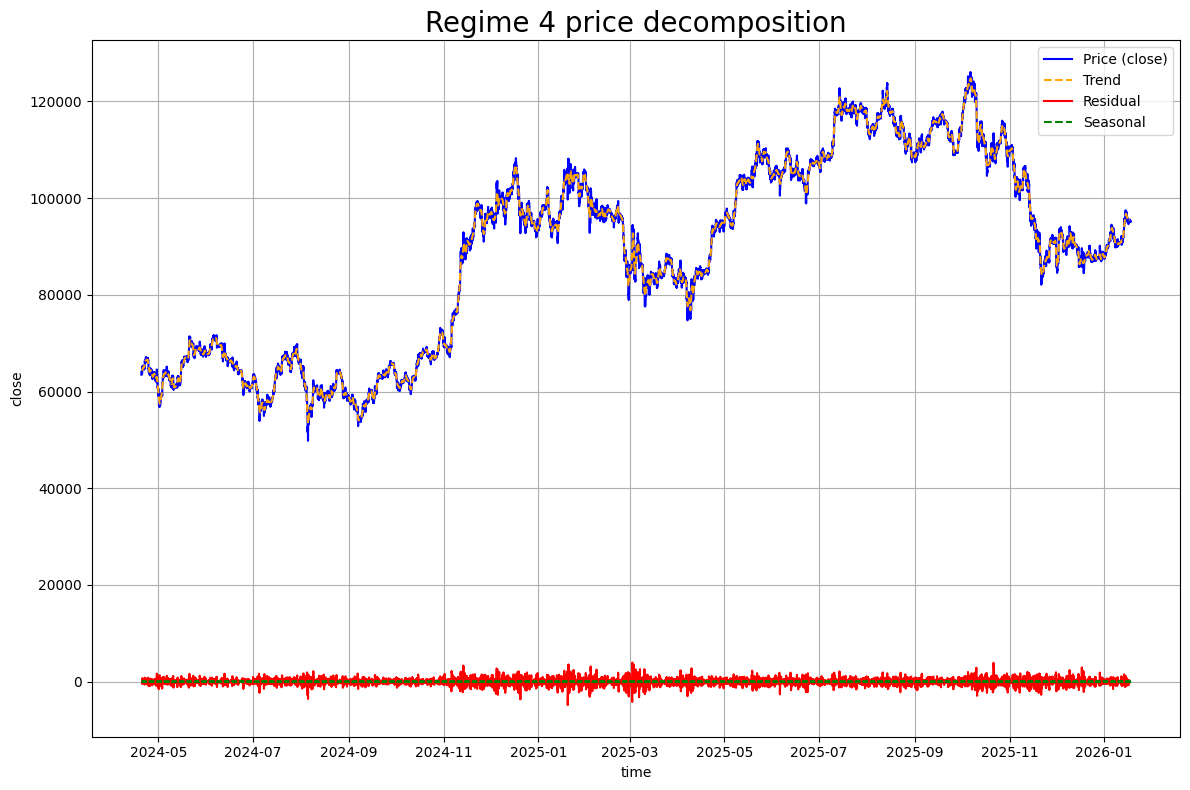

In [45]:
print("===============================")
print("STEP 2) DECOMPOSE TIME-SERIES")
print("===============================")

# -------------------------------
# 1. DETERMINE SEASONAL PERIOD (m)
# -------------------------------
log("AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m)", icon="1.", bold=True)
period, period_origin = decide_seasonal_period(
    timeseries=timeseries,
    granularity=granularity,
    manual_period=seasonal_period
)
log(f"-> Selected seasonal period (m)={period} for '{granularity}' granularity", icon="SUCCESS", level=2, bold=True)
print("\n")

# -------------------------------
# 2. GLOBAL SEASONALITY (ON RETURNS)
# -------------------------------
log("GLOBAL SEASONALITY (ON RETURNS) (LOG-DIFF)", icon="2.", bold=True)
# Using returns is preferred for seasonality detection because:
# - Prices are often non-stationary (trend + unit roots).
# - Returns stabilize variance and remove trends, making seasonal structure easier to detect.
# - Seasonality in price can be distorted by long-term drift; returns isolate cyclical effects.
if len(timeseries) < period * 3:
    raise ValueError(f"Not enough samples for decomposition: n={len(timeseries)} < 3*period={period*3}")
returns = generate_returns(timeseries, method="log")
if len(returns) < period * 3:
    raise ValueError(f"Not enough samples for returns decomposition: n={len(returns)} < 3*period={period*3}")
try:
    decomposition_ret = seasonal_decompose(x=returns, model="additive", period=period)
    trend_ret = decomposition_ret.trend
    seasonal_ret = decomposition_ret.seasonal
    residual_ret = decomposition_ret.resid
except Exception as e:
    raise ValueError(f"Returns decomposition failed: {e}")
strong_seasonality_global, metrics_global = assess_seasonality_strength(
    original=returns,
    seasonal=seasonal_ret,
    period=period,
    acf_threshold=0.2,
    var_ratio=0.02
)
if strong_seasonality_global:
    log(f"STRONG SEASONALITY detected for GLOBAL timeseries (var_ratio={metrics_global['seasonal_var_ratio']:.3f},acf={metrics_global['acf_at_period']:.3f}) -> Recommendation: try SARIMA for GLOBAL timeseries with seasonal period m={period}", icon="SUGGESTION", level=2)
else:
    log(f"WEAK SEASONALITY detected for GLOBAL timeseries (var_ratio={metrics_global['seasonal_var_ratio']:.3f},acf={metrics_global['acf_at_period']:.3f}) -> Recommendation: try ARIMA as baseline for GLOBAL timeseries (no clear seasonality detected)", icon="SUGGESTION", level=2)
print("\n")

# -------------------------------
# 3) HALVING-REGIME SEASONALITY (ON RETURNS)
# -------------------------------
log("HALVING-REGIME SEASONALITY (ON RETURNS) (LOG-DIFF)", icon="3.", bold=True)
regime_metrics = []
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} has not enough samples for decomposition: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue
    seg_returns = generate_returns(seg, method="log")
    if len(seg_returns) < period * 3:
        log(f"Regime {i+1} has not enough samples for returns decomposition: n={len(seg_returns)} < 3*period", icon="WARNING", level=2)
        continue
    try:
        dec = seasonal_decompose(x=seg_returns, model="additive", period=period)
        strong, metrics = assess_seasonality_strength(
            original=seg_returns,
            seasonal=dec.seasonal,
            period=period,
            acf_threshold=0.2,
            var_ratio=0.02
        )
        regime_metrics.append({
            "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
            "n": len(seg_returns),
            "strong": strong,
            "var_ratio": metrics["seasonal_var_ratio"],
            "acf_at_period": metrics["acf_at_period"]
        })
        if strong:
            log(f"STRONG SEASONALITY detected for REGIME {i+1} ({edges[i]} - {edges[i+1]}) (var_ratio={metrics['seasonal_var_ratio']:.3f},acf={metrics['acf_at_period']:.3f}) -> Recommendation: try SARIMA for REGIME {i+1} with seasonal period m={period}", icon="SUGGESTION", level=2)
        else:
            log(f"WEAK SEASONALITY detected for REGIME {i+1} ({edges[i]} - {edges[i+1]}) (var_ratio={metrics['seasonal_var_ratio']:.3f},acf={metrics['acf_at_period']:.3f}) -> Recommendation: try ARIMA as baseline for REGIME {i+1} (no clear seasonality detected)", icon="SUGGESTION", level=2)
    except Exception as e:
        log(f"Regime {i+1} decomposition failed: {e}", icon="WARNING", level=3)
print("\n")

# -------------------------------
# 4) SEASONALITY CONSISTENCY CHECK 
# -------------------------------
log("SEASONALITY CONSISTENCY CHECK", icon="4.", bold=True)
# 1) If global seasonality is tiny, don't over-interpret regime variation
GLOBAL_WEAK_VR = 0.01   # 1% seasonal variance ratio
GLOBAL_WEAK_ACF = 0.10  # small ACF at period

global_weak = (metrics_global["seasonal_var_ratio"] < GLOBAL_WEAK_VR) and \
              (abs(metrics_global["acf_at_period"]) < GLOBAL_WEAK_ACF)

# 2) Compare each regime to global with absolute thresholds
DELTA_VR = 0.01   # absolute var_ratio change
DELTA_ACF = 0.10  # absolute ACF change

if not regime_metrics:
    log("No valid regime metrics -> default to global", icon="WARNING", level=2)
    seasonality_strategy = "global"
else:
    diffs_vr = [abs(m["var_ratio"] - metrics_global["seasonal_var_ratio"]) for m in regime_metrics]
    diffs_acf = [abs(m["acf_at_period"] - metrics_global["acf_at_period"]) for m in regime_metrics]

    frac_vr = np.mean([diffs > DELTA_VR for diffs in diffs_vr])
    frac_acf = np.mean([diffs > DELTA_ACF for diffs in diffs_acf])

    log(f"Abs deltas vs global -> var_ratio mean={np.mean(diffs_vr):.3f}, acf mean={np.mean(diffs_acf):.3f}", icon="INFO", level=2)
    log(f"Frac regimes above threshold -> var_ratio={frac_vr:.2f}, acf={frac_acf:.2f}", icon="INFO", level=2)

    if global_weak and (frac_vr < 0.25 and frac_acf < 0.25):
        log("Global seasonality is weak and regimes are similar -> GLOBAL analysis is acceptable", icon="SUCCESS", level=2)
        seasonality_strategy = "global"
    elif (frac_vr > 0.6 or frac_acf > 0.6):
        log("Large regime deviations from global -> PER_REGIME analysis seems more adequated", icon="WARNING", level=2)
        seasonality_strategy = "per_regime"
    else:
        log("Mixed signal -> use MIXED strategy", icon="INFO", level=2)
        seasonality_strategy = "mixed"
print("\n")

# -------------------------------
# 5.1) RETURN RESIDUAL DIAGNOSTICS (GLOBAL)
# -------------------------------
log("RETURN RESIDUAL DIAGNOSTICS (GLOBAL)", icon="5.1.", bold=True)
run_residual_diagnostics(residual_ret, label="GLOBAL")
print("\n")

# -------------------------------
# 5.2) RETURN RESIDUAL DIAGNOSTICS (PER-REGIME)
# -------------------------------
log("RETURN RESIDUAL DIAGNOSTICS (PER-REGIME)", icon="5.2.", bold=True)
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue
    seg_returns = generate_returns(seg, method="log")
    if len(seg_returns) < period * 3:
        log(f"Regime {i+1} returns too short: n={len(seg_returns)} < 3*period", icon="WARNING", level=2)
        continue
    try:
        dec = seasonal_decompose(x=seg_returns, model="additive", period=period)
        run_residual_diagnostics(dec.resid, label=f"Regime {i+1}")
    except Exception as e:
        log(f"Regime {i+1} residual diagnostics failed: {e}", icon="WARNING", level=2)
print("\n")

# -------------------------------
# 6.1) PRICE DECOMPOSITION (GLOBAL)
# -------------------------------
log("PRICE DECOMPOSITION (GLOBAL)", icon="6.1.", bold=True)
try:
    decomposition_price = seasonal_decompose(x=timeseries, model="additive", period=period)
    trend_price = decomposition_price.trend
    seasonal_price = decomposition_price.seasonal
    residual_price = decomposition_price.resid
    log("Price decomposition completed successfully", icon="SUCCESS", level=2)
except Exception as e:
    raise ValueError(f"Price decomposition failed: {e}")

fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
sns.lineplot(data=timeseries, color="blue", label="Price (close)")
sns.lineplot(data=trend_price, color="orange", label="Trend", linestyle="--")
sns.lineplot(data=residual_price, color="red", label="Residual")
sns.lineplot(data=seasonal_price, color="green", label="Seasonal", linestyle="--")
axis.set_title(f"GLOBAL price decomposition", fontsize=plot_title_font_size)
plt.grid(True)
plt.tight_layout()
plt.show()
print("\n")

# -------------------------------
# 6.2) PRICE DECOMPOSITION (PER-REGIME)
# -------------------------------
log("PRICE DECOMPOSITION (PER-REGIME)", icon="6.2.", bold=True)
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)

    # Require enough samples for seasonal decomposition
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue

    try:
        dec_price = seasonal_decompose(x=seg, model="additive", period=period)
        trend_r = dec_price.trend
        seasonal_r = dec_price.seasonal
        residual_r = dec_price.resid
        log(f"Regime {i+1} price decomposition completed successfully", icon="SUCCESS", level=2)
    except Exception as e:
        log(f"Regime {i+1} price decomposition failed: {e}", icon="WARNING", level=2)
        continue

    fig, axis = plt.subplots(figsize=(figWidth_unit, figHeight_unit))
    sns.lineplot(data=seg, color="blue", label="Price (close)")
    sns.lineplot(data=trend_r, color="orange", label="Trend", linestyle="--")
    sns.lineplot(data=residual_r, color="red", label="Residual")
    sns.lineplot(data=seasonal_r, color="green", label="Seasonal", linestyle="--")
    axis.set_title(f"Regime {i+1} price decomposition", fontsize=plot_title_font_size)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


STEP 3) STATIONARITY (ADF) -> INFER d AND D (FOR SARIMA)

In [ ]:
print("===============================")
print("STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)")
print("===============================")

# -------------------------------
# 1) GLOBAL STATIONARITY (ADF)
# -------------------------------
log("GLOBAL STATIONARITY (ADF) -> infer d", icon="1.", bold=True)
series_adf_base = timeseries.dropna().astype(float)
adf_base = test_stationarity(series=series_adf_base)
log("DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY (GLOBAL)", icon="FOUND", level=2)
print(adf_base.to_string(dtype=False))

if adf_base["p-value"] < accepted_alpha_dickey_fuller:
    d_global = 0
    series_stationary_nonseasonal = series_adf_base
    log(f"Reject H0 at alpha={accepted_alpha_dickey_fuller}: series is stationary -> d_global={d_global}", icon="SUCCESS", level=3)
else:
    log("Fail to reject H0 -> applying recursive differencing to infer d_global", icon="WARNING", level=3)
    series_stationary_nonseasonal, d_global, adf_after_diff = make_stationary_recursive(
        series=series_adf_base, alpha=accepted_alpha_dickey_fuller
    )
    log(f"ADF after differencing (d_global={d_global})", icon="FOUND", level=2)
    display(adf_after_diff)
    if d_global > 2:
        log(f"High differencing order detected (d_global={d_global}). Consider log/returns modeling.", icon="WARNING", level=3)
    if adf_after_diff["p-value"] < accepted_alpha_dickey_fuller:
        log(f"Reject H0 after differencing -> stationary achieved with d_global={d_global}", icon="SUCCESS", level=3)
    else:
        log(f"Fail to reject H0 after differencing up to d_global={d_global}", icon="WARNING", level=3)
print("\n")

# -------------------------------
# 2) GLOBAL SEASONAL DIFFERENCING (D)
# -------------------------------
log("GLOBAL SEASONAL DIFFERENCING (D) -> infer D", icon="2.", bold=True)
D_global = 0
if period is None or period <= 1:
    log("No valid seasonal period m -> keep D_global=0", icon="WARNING", level=2)
else:
    if not strong_seasonality_global:
        log("Global seasonality is weak (STEP 2) -> keep D_global=0", icon="WARNING", level=2, bold=True)
        D_global = 0
    else:
        log("Global seasonality is strong -> evaluate D_global using ADF on d-differenced series", level=2, bold=True)
        series_for_D = series_adf_base.copy()
        if d_global > 0:
            series_for_D = series_for_D.diff(d_global).dropna()
        if len(series_for_D) < max(60, period * 5):
            log("Not enough data after differencing -> keep D_global=0", icon="WARNING", level=2)
            D_global = 0
        else:
            adf_ref = test_stationarity(series=series_for_D)
            log(f"ADF (after d_global={d_global}, no seasonal diff): {adf_ref}", level=2)
            series_for_D_seasonal = series_for_D.diff(period).dropna()
            if len(series_for_D_seasonal) < max(60, period * 5):
                log("Not enough data after seasonal diff -> keep D_global=0", icon="WARNING", level=2)
                D_global = 0
            else:
                adf_seasonal = test_stationarity(series=series_for_D_seasonal)
                log(f"ADF (after d_global={d_global} and seasonal diff): {adf_seasonal}", level=2)
                if adf_seasonal["p-value"] < accepted_alpha_dickey_fuller:
                    D_global = 1
                    log(f"Reject H0 after seasonal differencing -> suggest D_global={D_global}", icon="SUCCESS", level=2, bold=True)
                else:
                    D_global = 0
                    log(f"Fail to reject H0 -> keep D_global={D_global}", icon="WARNING", level=2, bold=True)
print("\n")

# -------------------------------
# 3) PER-REGIME STATIONARITY (ADF)
# -------------------------------
log("PER-REGIME STATIONARITY (ADF) -> infer d_regime and D_regime", icon="3.", bold=True)
regime_stationarity = []

for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue

    # d_regime
    adf_seg = test_stationarity(series=seg)
    if adf_seg["p-value"] < accepted_alpha_dickey_fuller:
        d_reg = 0
        seg_stationary = seg
        log(f"Regime {i+1}: stationary -> d_reg={d_reg}", icon="SUCCESS", level=2)
    else:
        seg_stationary, d_reg, adf_after = make_stationary_recursive(series=seg, alpha=accepted_alpha_dickey_fuller)
        log(f"Regime {i+1}: differenced to reach stationarity -> d_reg={d_reg}", icon="INFO", level=2)
        if d_reg > 2:
            log(f"Regime {i+1}: high differencing (d_reg={d_reg})", icon="WARNING", level=2)

    # D_regime
    D_reg = 0
    if period is None or period <= 1:
        D_reg = 0
    else:
        # Use regime-level seasonality if available
        strong_regime = None
        for m in regime_metrics:
            if m["label"].startswith(f"Regime {i+1}:"):
                strong_regime = m["strong"]
                break

        # Only evaluate seasonal differencing if regime seasonality is strong
        if strong_regime is True:
            series_for_D = seg.copy()
            if d_reg > 0:
                series_for_D = series_for_D.diff(d_reg).dropna()
            if len(series_for_D) < max(60, period * 5):
                D_reg = 0
            else:
                series_for_D_seasonal = series_for_D.diff(period).dropna()
                if len(series_for_D_seasonal) < max(60, period * 5):
                    D_reg = 0
                else:
                    adf_seasonal = test_stationarity(series=series_for_D_seasonal)
                    if adf_seasonal["p-value"] < accepted_alpha_dickey_fuller:
                        D_reg = 1
        else:
            D_reg = 0

    regime_stationarity.append({
        "label": f"Regime {i+1}: {edges[i].date()} -> {edges[i+1].date()}",
        "d_reg": d_reg,
        "D_reg": D_reg
    })
    log(f"Regime {i+1}: d_reg={d_reg}, D_reg={D_reg}", icon="INFO", level=2)

print("\n")

# -------------------------------
# 4) MODELS PARAMETERS RECOMMENDATION
# -------------------------------
log("MODELS PARAMETERS RECOMMENDATION", icon="4.", bold=True)
log(f"GLOBAL -> ARIMA d={d_global} | SARIMA D={D_global}, m={period}", icon="SUGGESTION", level=2)
if regime_stationarity:
    for r in regime_stationarity:
        log(f"{r['label']} -> ARIMA d={r['d_reg']} | SARIMA D={r['D_reg']}, m={period}", icon="SUGGESTION", level=2)

STEP 3) STATIONARITY (ADF) -> INFER d (FOR ARIMA & SARIMA) AND D (FOR SARIMA)
• 1. GLOBAL STATIONARITY (ADF) -> infer d
   - 🔍 DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY (GLOBAL)
Test Statistic                    -0.246382
p-value                            0.932762
#Lags Used                        64.000000
Number of Observations Used    96560.000000
Critical Value (1%)               -3.430418
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
      · ⚠️ Fail to reject H0 -> applying recursive differencing to infer d_global
   - 🔍 ADF after differencing (d_global=1)


Test Statistic                   -37.589897
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    96556.000000
Critical Value (1%)               -3.430418
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64

      · ✅ Reject H0 after differencing -> stationary achieved with d_global=1


• 2. GLOBAL SEASONAL DIFFERENCING (D) -> infer D
   - ⚠️ Global seasonality is weak (STEP 2) -> keep D_global=0


• 3. PER-REGIME STATIONARITY (ADF) -> infer d_regime and D_regime
   - ℹ️ Regime 1: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 1: d_reg=1, D_reg=0
   - ℹ️ Regime 2: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 2: d_reg=1, D_reg=0
   - ℹ️ Regime 3: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 3: d_reg=1, D_reg=0
   - ℹ️ Regime 4: differenced to reach stationarity -> d_reg=1
   - ℹ️ Regime 4: d_reg=1, D_reg=0


• 4. MODELS PARAMETERS RECOMMENDATION
   - 💡 GLOBAL -> ARIMA d=1 | SARIMA D=0, m=24
   - 💡 Regime 1: 2015-01-10 -> 2016-07-09 -> ARIMA d=1 | SARIMA D=0, m=24
   - 💡 Regime 2: 2016-07-09 -> 2020-05-11 -> ARIMA d=1 | SARIMA D=0, m=24
   - 💡 Regime 3: 2020-05-11 -> 2024-04-20 -> ARIMA d=1 | SARIMA D=0, m=24
   - 💡 Regime 4: 2024-04-20 -> 2026-01-1

STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (ARIMA vs SARIMA)

STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (GLOBAL + REGIME)
• 1. PREPARE DIAGNOSTIC SERIES
   - ✅ Applied pandas frequency 'h' for diagnostics.
   - ℹ️ GLOBAL diagnostics prepared with d=1 (n=96624)
   - ℹ️ Regime 1 diagnostics prepared with d=1 (n=13104)
   - ℹ️ Regime 2 diagnostics prepared with d=1 (n=33648)
   - ℹ️ Regime 3 diagnostics prepared with d=1 (n=34560)
   - ℹ️ Regime 4 diagnostics prepared with d=1 (n=15312)
• 2. NON-SEASONAL ACF/PACF
   - ℹ️ GLOBAL: p~1, q~1, d=1, D=0


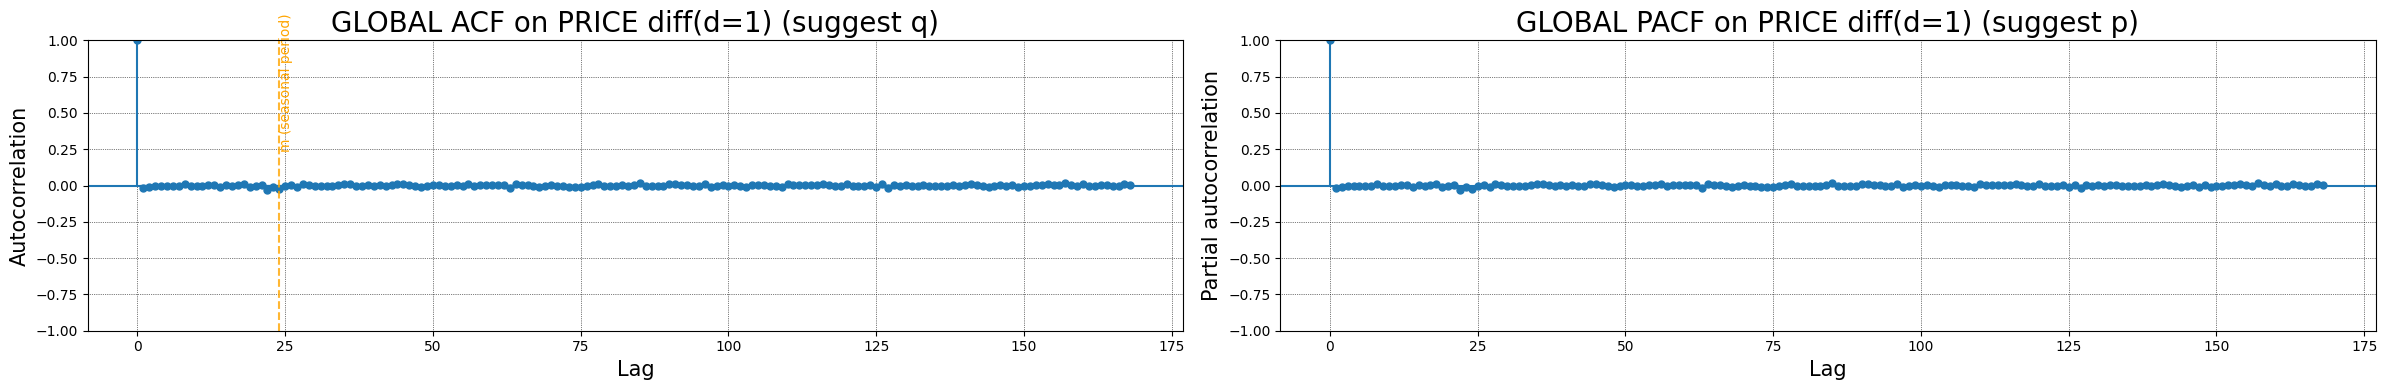

   - ℹ️ REGIME 1: p~1, q~1, d=1, D=0


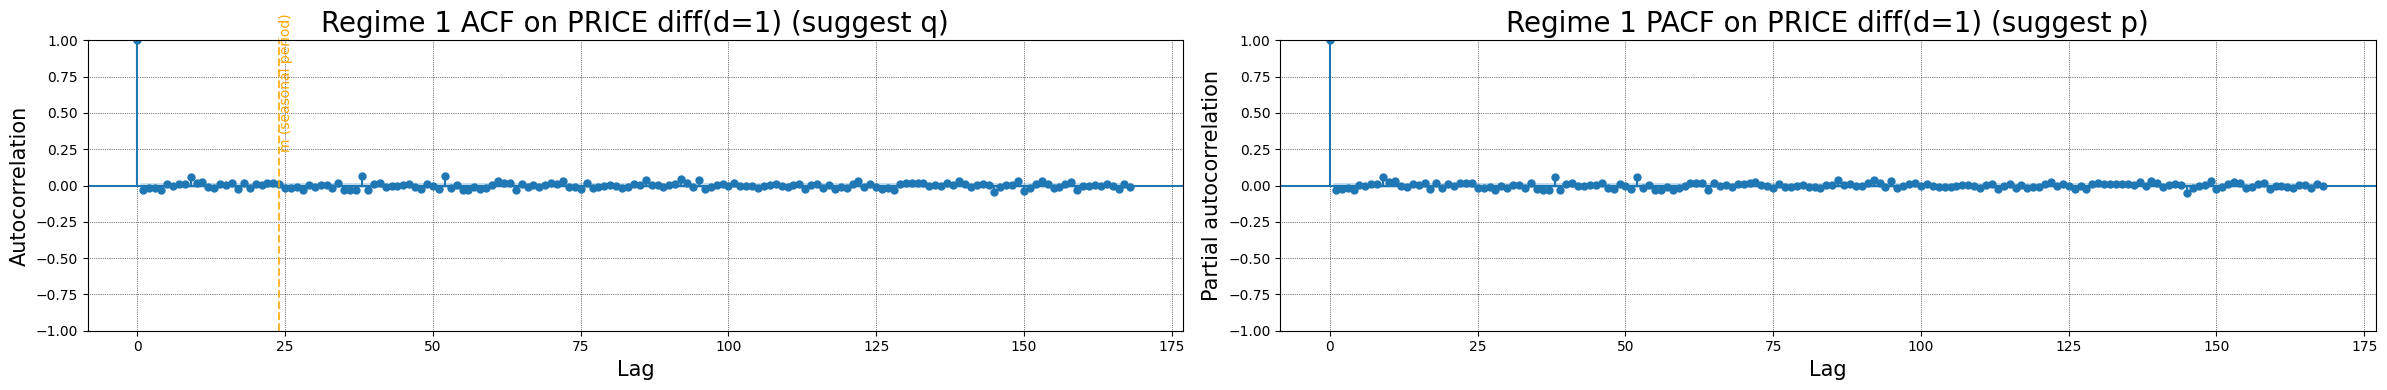

   - ℹ️ REGIME 2: p~1, q~1, d=1, D=0


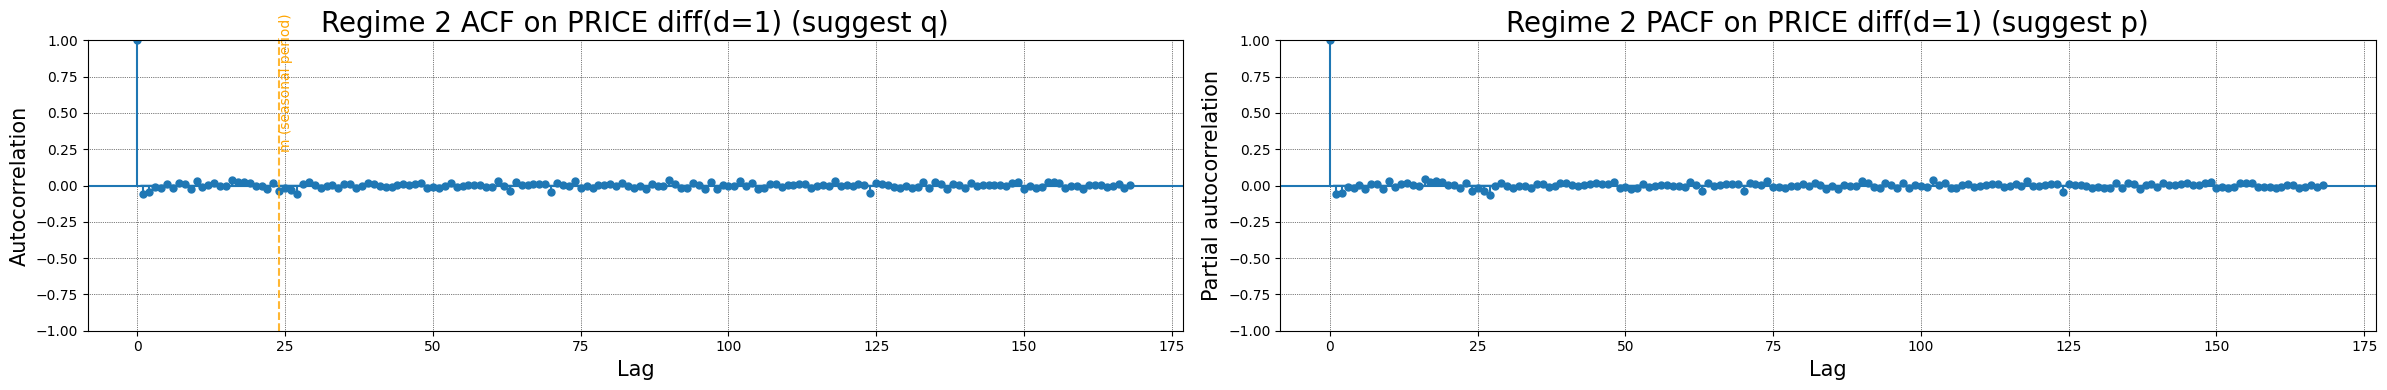

   - ℹ️ REGIME 3: p~2, q~2, d=1, D=0


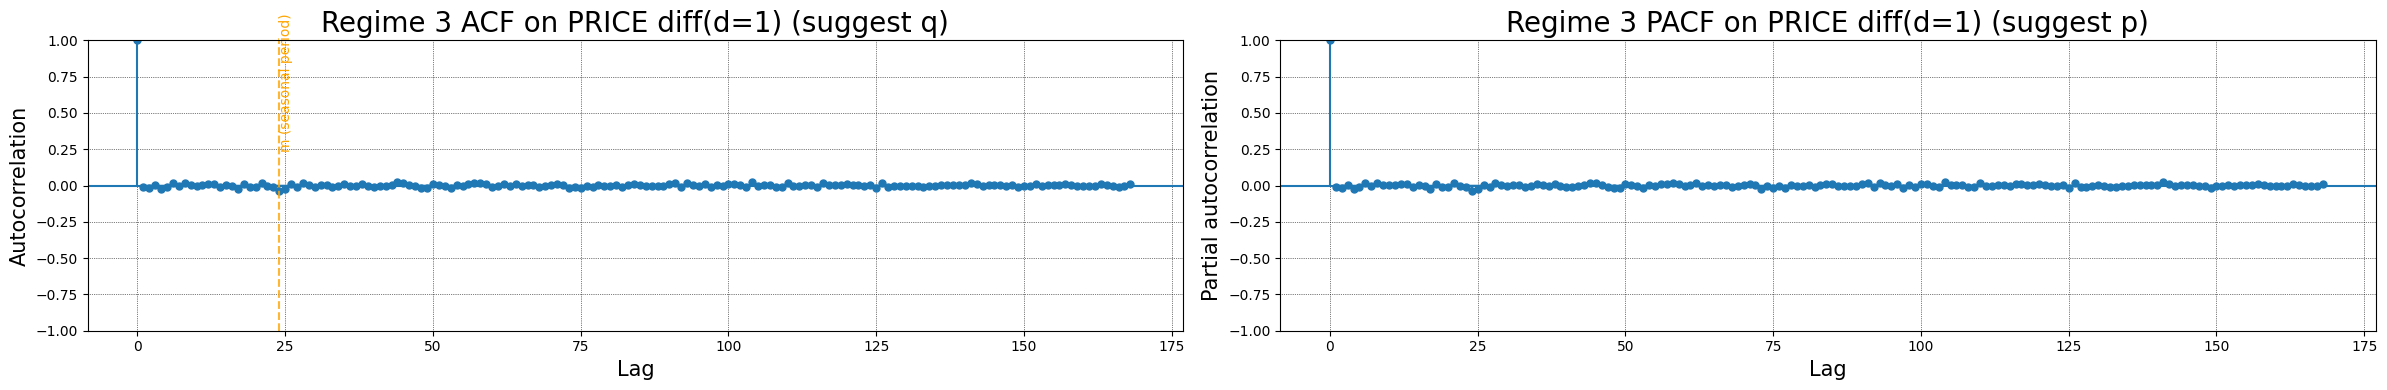

   - ℹ️ REGIME 4: p~1, q~1, d=1, D=0


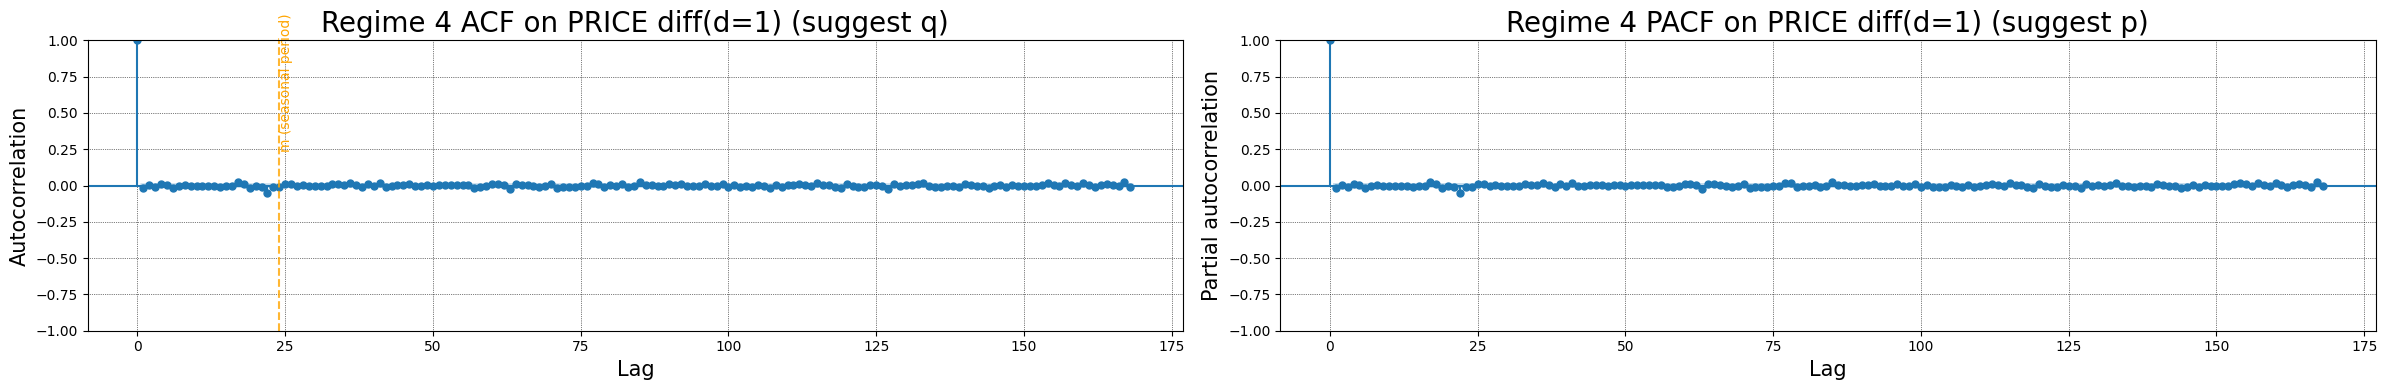

• 3. SEASONAL ACF/PACF
   - ℹ️ GLOBAL: P~1, Q~1, d=1, D=0


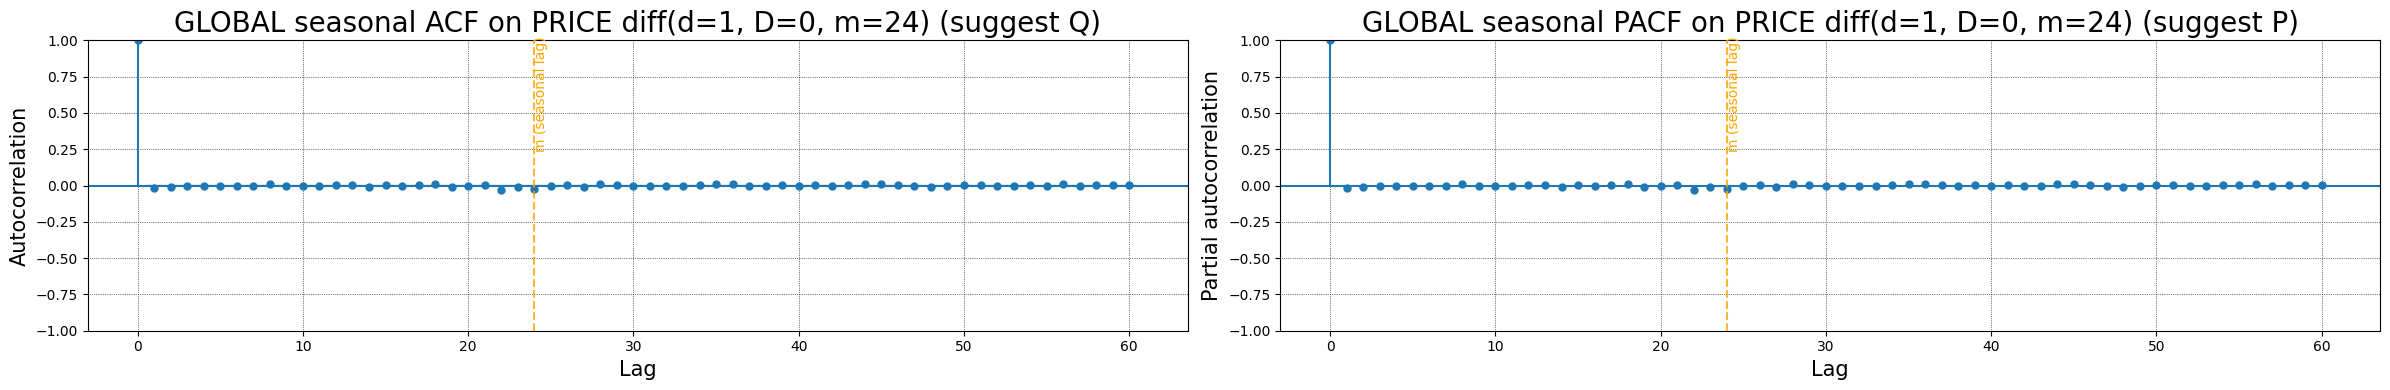

   - ℹ️ REGIME 1: P~1, Q~1, d=1, D=0


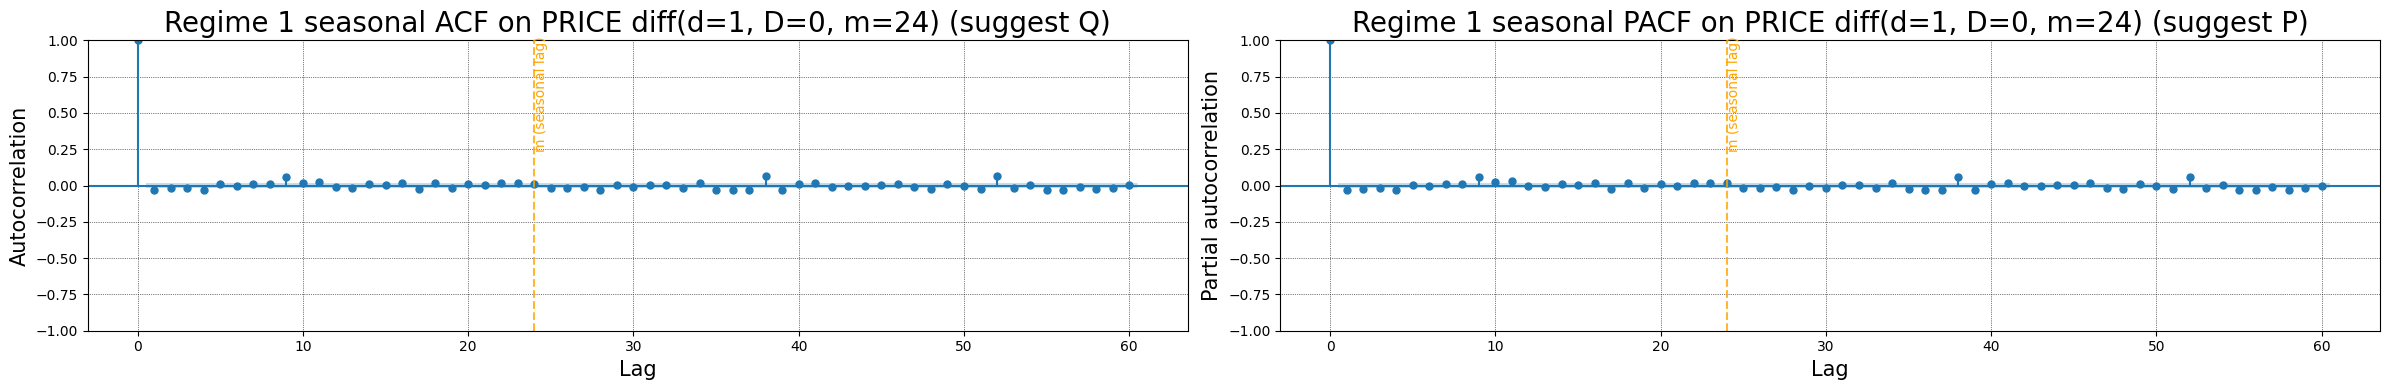

   - ℹ️ REGIME 2: P~1, Q~1, d=1, D=0


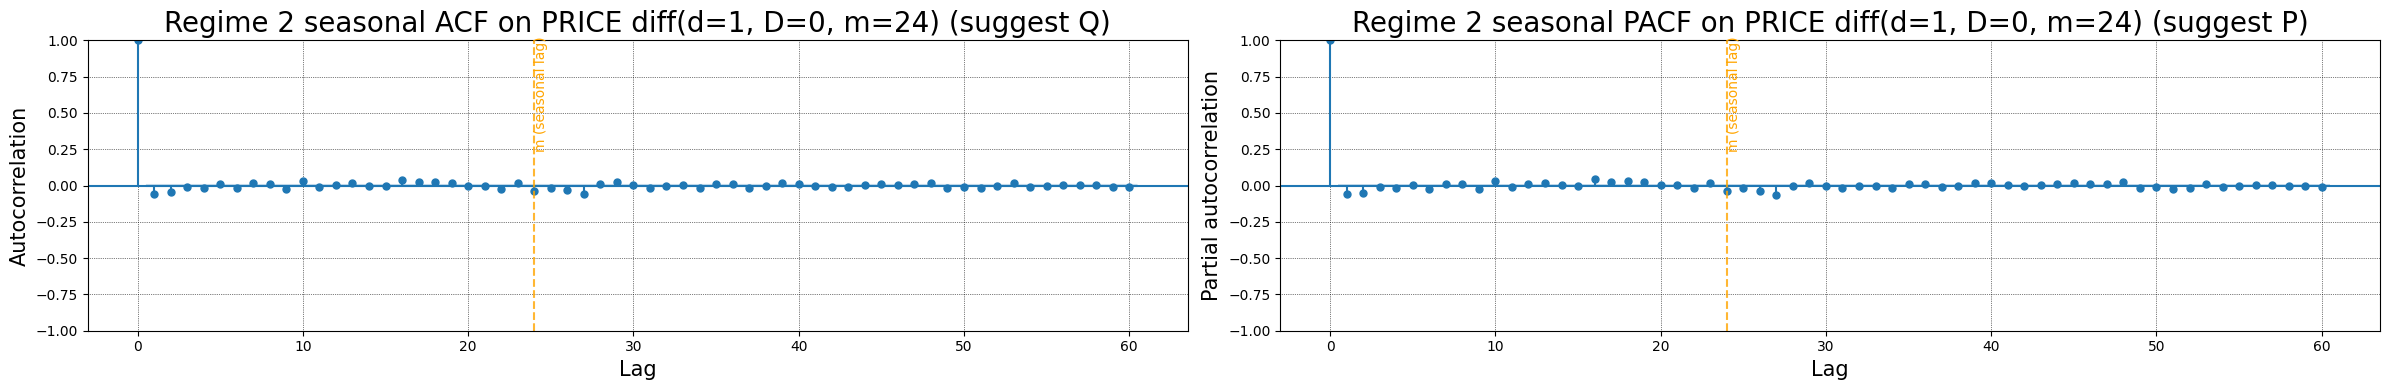

   - ℹ️ REGIME 3: P~1, Q~1, d=1, D=0


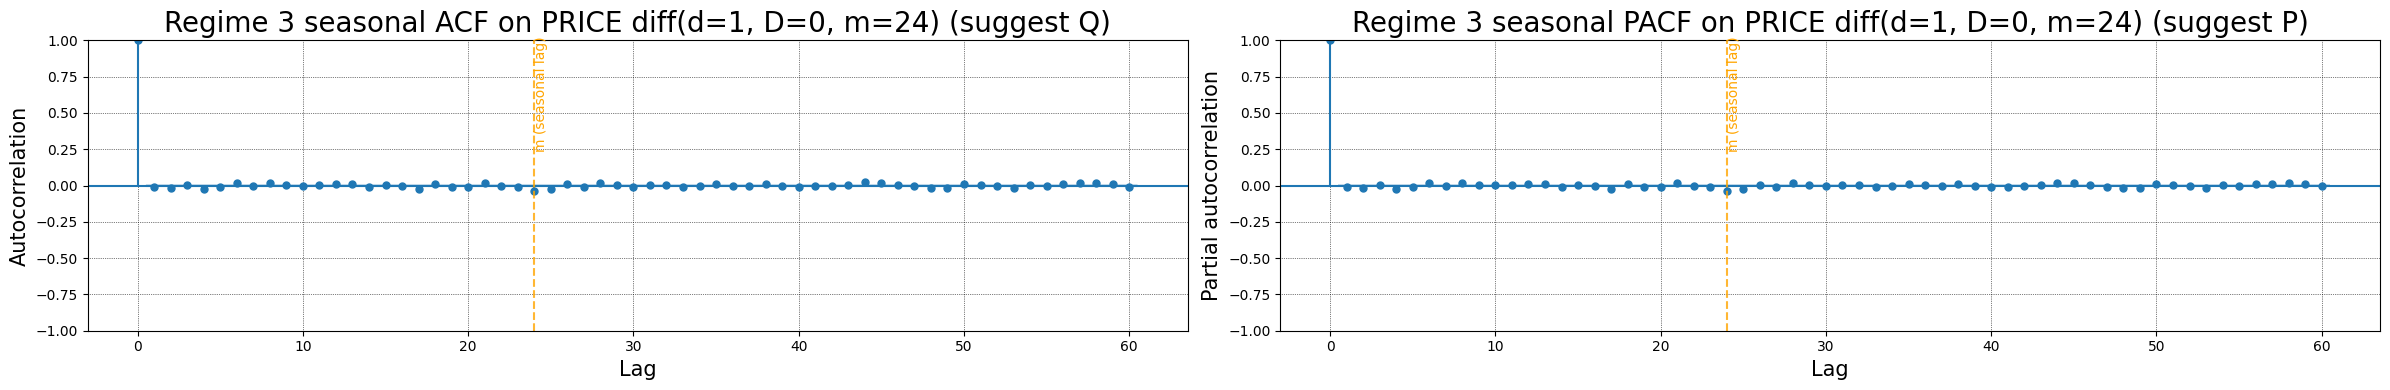

   - ℹ️ REGIME 4: P~0, Q~0, d=1, D=0


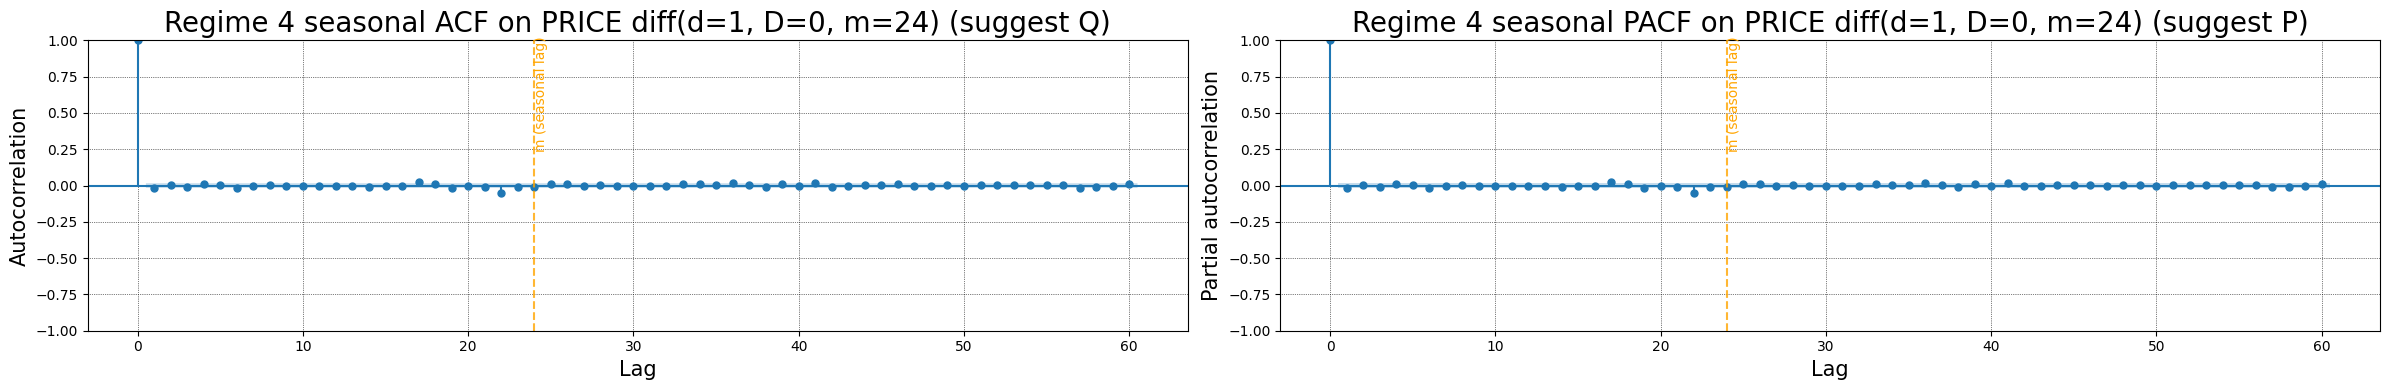

• 4. AIC/BIC GRID CHECK + REDUCE GRIDS
   - ℹ️ GLOBAL Top ARIMA by AIC: (p,d,q)=(1,1,1) | AIC=1331740.42 BIC=1331768.86; (p,d,q)=(0,1,1) | AIC=1331747.69 BIC=1331766.65; (p,d,q)=(1,1,0) | AIC=1331760.87 BIC=1331779.82; (p,d,q)=(0,1,0) | AIC=1331781.85 BIC=1331791.33
   - ℹ️ GLOBAL Top ARIMA by BIC: (p,d,q)=(0,1,1) | AIC=1331747.69 BIC=1331766.65; (p,d,q)=(1,1,1) | AIC=1331740.42 BIC=1331768.86; (p,d,q)=(1,1,0) | AIC=1331760.87 BIC=1331779.82; (p,d,q)=(0,1,0) | AIC=1331781.85 BIC=1331791.33
   - ℹ️ GLOBAL Top SARIMA by AIC: (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=1331388.93 BIC=1331426.84; (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=1331396.89 BIC=1331425.33; (p,d,q)=(1,1,0) (P,D,Q,m)=(0,0,1,24) | AIC=1331410.11 BIC=1331438.54; (p,d,q)=(0,1,0) (P,D,Q,m)=(0,0,1,24) | AIC=1331431.97 BIC=1331450.93; (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,0,24) | AIC=1331740.42 BIC=1331768.86
   - ℹ️ GLOBAL Top SARIMA by BIC: (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=1331396.89 BIC=1331425.33; (p,d,q)=(1,1,1) (P

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\t

   - ℹ️ Regime 1 Top ARIMA by AIC: (p,d,q)=(1,1,1) | AIC=62690.86 BIC=62713.31; (p,d,q)=(0,1,1) | AIC=62700.26 BIC=62715.22; (p,d,q)=(1,1,0) | AIC=62705.19 BIC=62720.15; (p,d,q)=(0,1,0) | AIC=62714.03 BIC=62721.51
   - ℹ️ Regime 1 Top ARIMA by BIC: (p,d,q)=(1,1,1) | AIC=62690.86 BIC=62713.31; (p,d,q)=(0,1,1) | AIC=62700.26 BIC=62715.22; (p,d,q)=(1,1,0) | AIC=62705.19 BIC=62720.15; (p,d,q)=(0,1,0) | AIC=62714.03 BIC=62721.51
   - ℹ️ Regime 1 Top SARIMA by AIC: (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=62583.92 BIC=62621.32; (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=62588.11 BIC=62618.02; (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,0,24) | AIC=62592.56 BIC=62622.48; (p,d,q)=(0,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=62592.67 BIC=62622.58; (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=62597.17 BIC=62619.61
   - ℹ️ Regime 1 Top SARIMA by BIC: (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=62588.11 BIC=62618.02; (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=62597.17 BIC=62619.61; (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,1,24) | 

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\t

   - ℹ️ Regime 2 Top ARIMA by AIC: (p,d,q)=(1,1,1) | AIC=387709.47 BIC=387734.74; (p,d,q)=(0,1,1) | AIC=387779.72 BIC=387796.57; (p,d,q)=(1,1,0) | AIC=387801.23 BIC=387818.07; (p,d,q)=(0,1,0) | AIC=387904.48 BIC=387912.90
   - ℹ️ Regime 2 Top ARIMA by BIC: (p,d,q)=(1,1,1) | AIC=387709.47 BIC=387734.74; (p,d,q)=(0,1,1) | AIC=387779.72 BIC=387796.57; (p,d,q)=(1,1,0) | AIC=387801.23 BIC=387818.07; (p,d,q)=(0,1,0) | AIC=387904.48 BIC=387912.90
   - ℹ️ Regime 2 Top SARIMA by AIC: (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=387400.46 BIC=387442.57; (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=387406.16 BIC=387439.85; (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,0,24) | AIC=387414.56 BIC=387448.25; (p,d,q)=(0,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=387477.99 BIC=387511.69; (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=387483.33 BIC=387508.60
   - ℹ️ Regime 2 Top SARIMA by BIC: (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=387406.16 BIC=387439.85; (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=387400.46 BIC=387442.57; (p,d,q)=(

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\t

   - ℹ️ Regime 3 Top ARIMA by AIC: (p,d,q)=(2,1,2) | AIC=483811.69 BIC=483853.94; (p,d,q)=(0,1,2) | AIC=483812.10 BIC=483837.45; (p,d,q)=(1,1,2) | AIC=483813.08 BIC=483846.88; (p,d,q)=(2,1,1) | AIC=483823.73 BIC=483857.53; (p,d,q)=(2,1,0) | AIC=483825.61 BIC=483850.97
   - ℹ️ Regime 3 Top ARIMA by BIC: (p,d,q)=(0,1,2) | AIC=483812.10 BIC=483837.45; (p,d,q)=(1,1,2) | AIC=483813.08 BIC=483846.88; (p,d,q)=(2,1,0) | AIC=483825.61 BIC=483850.97; (p,d,q)=(0,1,1) | AIC=483836.38 BIC=483853.28; (p,d,q)=(2,1,2) | AIC=483811.69 BIC=483853.94
   - ℹ️ Regime 3 Top SARIMA by AIC: (p,d,q)=(1,1,2) (P,D,Q,m)=(1,0,1,24) | AIC=483449.37 BIC=483500.07; (p,d,q)=(2,1,2) (P,D,Q,m)=(1,0,1,24) | AIC=483451.49 BIC=483510.63; (p,d,q)=(0,1,2) (P,D,Q,m)=(1,0,1,24) | AIC=483451.72 BIC=483493.97; (p,d,q)=(2,1,2) (P,D,Q,m)=(0,0,1,24) | AIC=483454.56 BIC=483505.26; (p,d,q)=(0,1,2) (P,D,Q,m)=(0,0,1,24) | AIC=483454.86 BIC=483488.66
   - ℹ️ Regime 3 Top SARIMA by BIC: (p,d,q)=(0,1,2) (P,D,Q,m)=(0,0,1,24) | AIC=483454.8

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\t

   - ℹ️ Regime 4 Top ARIMA by AIC: (p,d,q)=(0,1,1) | AIC=229183.01 BIC=229198.29; (p,d,q)=(1,1,1) | AIC=229184.36 BIC=229207.27; (p,d,q)=(1,1,0) | AIC=229197.06 BIC=229212.33; (p,d,q)=(0,1,0) | AIC=229199.87 BIC=229207.50
   - ℹ️ Regime 4 Top ARIMA by BIC: (p,d,q)=(0,1,1) | AIC=229183.01 BIC=229198.29; (p,d,q)=(1,1,1) | AIC=229184.36 BIC=229207.27; (p,d,q)=(0,1,0) | AIC=229199.87 BIC=229207.50; (p,d,q)=(1,1,0) | AIC=229197.06 BIC=229212.33
   - ℹ️ Regime 4 Top SARIMA by AIC: (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=228840.17 BIC=228863.08; (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=228841.48 BIC=228872.02; (p,d,q)=(0,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=228842.13 BIC=228872.67; (p,d,q)=(1,1,1) (P,D,Q,m)=(1,0,1,24) | AIC=228843.70 BIC=228881.87; (p,d,q)=(1,1,0) (P,D,Q,m)=(0,0,1,24) | AIC=228854.78 BIC=228877.69
   - ℹ️ Regime 4 Top SARIMA by BIC: (p,d,q)=(0,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=228840.17 BIC=228863.08; (p,d,q)=(1,1,1) (P,D,Q,m)=(0,0,1,24) | AIC=228841.48 BIC=228872.02; (p,d,q)=(

,scope,model,p,d,q,P,D,Q,m
0,GLOBAL,ARIMA,0,1,0,n/a,n/a,n/a,n/a
1,GLOBAL,ARIMA,0,1,1,n/a,n/a,n/a,n/a
2,GLOBAL,ARIMA,1,1,0,n/a,n/a,n/a,n/a
3,GLOBAL,ARIMA,1,1,1,n/a,n/a,n/a,n/a
4,GLOBAL,SARIMA,0,1,0,0,0,1,24
5,GLOBAL,SARIMA,0,1,1,0,0,0,24
6,GLOBAL,SARIMA,0,1,1,0,0,1,24
7,GLOBAL,SARIMA,1,1,0,0,0,1,24
8,GLOBAL,SARIMA,1,1,1,0,0,0,24
9,GLOBAL,SARIMA,1,1,1,0,0,1,24


In [54]:
print("===============================")
print("STEP 4) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (GLOBAL + REGIME)")
print("===============================")

# -------------------------------
# 1) PREPARE DIAGNOSTIC SERIES
# -------------------------------
log("PREPARE DIAGNOSTIC SERIES", icon="1.", bold=True)
# GLOBAL
series_for_diag = timeseries.dropna().astype(float).copy()
freq = get_pandas_freq_from_granularity(granularity)
if freq is not None:
    try:
        series_for_diag = series_for_diag.asfreq(freq)
        log(f"Applied pandas frequency '{freq}' for diagnostics.", icon="SUCCESS", level=2)
    except Exception as e:
        log(f"Could not apply pandas frequency '{freq}': {e}", icon="WARNING", level=2)
else:
    log(f"No pandas freq mapping for granularity='{granularity}' -> skipping asfreq.", icon="WARNING", level=2)

series_for_diag, series_diag_ns = prepare_diag_series(series_for_diag, d_global, "GLOBAL")
# REGIMES (store prepared series for later steps)
regime_diag = {}  # {reg_id: {"base": ..., "diag": ..., "d_reg": ..., "D_reg": ...}}
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < period * 3:
        log(f"Regime {i+1} skipped: n={len(seg)} < 3*period", icon="WARNING", level=2)
        continue
    # Fetch d_reg, D_reg from Step 3
    d_reg = None
    D_reg = 0
    for r in regime_stationarity:
        if r["label"].startswith(f"Regime {i+1}:"):
            d_reg = r["d_reg"]
            D_reg = r["D_reg"]
            break
    if d_reg is None:
        log(f"Regime {i+1}: no d_reg found -> skipped", icon="WARNING", level=2)
        continue
    seg_base, seg_diag = prepare_diag_series(seg, d_reg, f"Regime {i+1}")
    regime_diag[i+1] = {
        "base": seg_base,
        "diag": seg_diag,
        "d_reg": d_reg,
        "D_reg": D_reg
    }
# -------------------------------
# 2) NON-SEASONAL ACF/PACF
# -------------------------------
log("NON-SEASONAL ACF/PACF", icon="2.", bold=True)

# GLOBAL
if len(series_diag_ns) < 30 or series_diag_ns.std() < 1e-8:
    log("GLOBAL ACF/PACF: series too short or almost constant -> p=q=0", icon="WARNING", level=2)
    suggested_p = 0
    suggested_q = 0
    log(f"GLOBAL: p~{suggested_p}, q~{suggested_q}, d={d_global}, D={D_global}", icon="INFO", level=2)
else:
    n = len(series_diag_ns)
    safe_lag = get_safe_lag_for_acf_pacf(granularity, period, n, max_cap=300)
    conf_limit = 1.96 / np.sqrt(n)
    ac_vals = acf(series_diag_ns, nlags=safe_lag, fft=True, missing="drop")
    pc_vals = pacf(series_diag_ns, nlags=safe_lag, method="ywm")
    sig_acf = [lag for lag in range(1, len(ac_vals)) if abs(ac_vals[lag]) > conf_limit]
    sig_pacf = [lag for lag in range(1, len(pc_vals)) if abs(pc_vals[lag]) > conf_limit]
    suggested_q = int(sig_acf[0]) if sig_acf else 0
    suggested_p = int(sig_pacf[0]) if sig_pacf else 0
    log(f"GLOBAL: p~{suggested_p}, q~{suggested_q}, d={d_global}, D={D_global}", icon="INFO", level=2)

    fig, axes = plt.subplots(1, 2, figsize=(2*figWidth_unit, 0.5*figHeight_unit))
    plot_acf(series_diag_ns, lags=safe_lag, ax=axes[0])
    axes[0].set_title(f"GLOBAL ACF on PRICE diff(d={d_global}) (suggest q)", fontsize=plot_title_font_size)
    axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
    axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
    axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
    if period is not None and period > 1 and period <= safe_lag:
        axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal period)", rotation=90, color="orange")

    plot_pacf(series_diag_ns, lags=safe_lag, ax=axes[1], method="ywm")
    axes[1].set_title(f"GLOBAL PACF on PRICE diff(d={d_global}) (suggest p)", fontsize=plot_title_font_size)
    axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
    axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
    axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
    plt.tight_layout()
    plt.show()
# REGIMES
for reg_id, info in regime_diag.items():
    seg_diag = info["diag"]
    d_reg = info["d_reg"]
    D_reg = info["D_reg"]

    if len(seg_diag) < 30 or seg_diag.std() < 1e-8:
        log(f"Regime {reg_id}: series too short or almost constant -> p=q=0", icon="WARNING", level=2)
        p_reg = 0
        q_reg = 0
        regime_diag[reg_id]["p_reg"] = p_reg
        regime_diag[reg_id]["q_reg"] = q_reg
        log(f"REGIME {reg_id}: p~{p_reg}, q~{q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)
    else:
        n = len(seg_diag)
        safe_lag = get_safe_lag_for_acf_pacf(granularity, period, n, max_cap=300)
        conf_limit = 1.96 / np.sqrt(n)
        ac_vals = acf(seg_diag, nlags=safe_lag, fft=True, missing="drop")
        pc_vals = pacf(seg_diag, nlags=safe_lag, method="ywm")
        sig_acf = [lag for lag in range(1, len(ac_vals)) if abs(ac_vals[lag]) > conf_limit]
        sig_pacf = [lag for lag in range(1, len(pc_vals)) if abs(pc_vals[lag]) > conf_limit]
        q_reg = int(sig_acf[0]) if sig_acf else 0
        p_reg = int(sig_pacf[0]) if sig_pacf else 0
        regime_diag[reg_id]["p_reg"] = p_reg
        regime_diag[reg_id]["q_reg"] = q_reg
        log(f"REGIME {reg_id}: p~{p_reg}, q~{q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)

        fig, axes = plt.subplots(1, 2, figsize=(2*figWidth_unit, 0.5*figHeight_unit))
        plot_acf(seg_diag, lags=safe_lag, ax=axes[0])
        axes[0].set_title(f"Regime {reg_id} ACF on PRICE diff(d={d_reg}) (suggest q)", fontsize=plot_title_font_size)
        axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
        axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        if period is not None and period > 1 and period <= safe_lag:
            axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
            axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal period)", rotation=90, color="orange")

        plot_pacf(seg_diag, lags=safe_lag, ax=axes[1], method="ywm")
        axes[1].set_title(f"Regime {reg_id} PACF on PRICE diff(d={d_reg}) (suggest p)", fontsize=plot_title_font_size)
        axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
        axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        plt.tight_layout()
        plt.show()

# -------------------------------
# 3) SEASONAL ACF/PACF
# -------------------------------
log("SEASONAL ACF/PACF", icon="3.", bold=True)
# GLOBAL
if period is None or period <= 1:
    log("Seasonal order suggestion skipped: invalid seasonal period m -> P=0, Q=0", icon="WARNING", level=2)
    suggested_P = 0
    suggested_Q = 0
    log(f"GLOBAL: P~{suggested_P}, Q~{suggested_Q}, d={d_global}, D={D_global}", icon="INFO", level=2)
else:
    series_diag_s = series_diag_ns.copy()
    if D_global > 0:
        series_diag_s = series_diag_s.diff(period).dropna()

    if len(series_diag_s) < max(60, period * 5):
        log("GLOBAL: Not enough points for seasonal ACF/PACF -> P=0, Q=0", icon="WARNING", level=2)
        suggested_P = 0
        suggested_Q = 0
        log(f"GLOBAL: P~{suggested_P}, Q~{suggested_Q}, d={d_global}, D={D_global}", icon="INFO", level=2)
    else:
        safe_lag_s = int(min(max(2 * period, 60), len(series_diag_s) - 2, 400))
        conf_limit_s = 1.96 / np.sqrt(len(series_diag_s))

        ac_s = acf(series_diag_s, nlags=safe_lag_s, fft=True, missing="drop")
        pc_s = pacf(series_diag_s, nlags=safe_lag_s, method="ywm")

        seasonal_lags = [k * period for k in range(1, (safe_lag_s // period) + 1)]
        sig_seasonal_acf = [L for L in seasonal_lags if L < len(ac_s) and abs(ac_s[L]) > conf_limit_s]
        sig_seasonal_pacf = [L for L in seasonal_lags if L < len(pc_s) and abs(pc_s[L]) > conf_limit_s]

        suggested_Q = 1 if sig_seasonal_acf else 0
        suggested_P = 1 if sig_seasonal_pacf else 0
        log(f"GLOBAL: P~{suggested_P}, Q~{suggested_Q}, d={d_global}, D={D_global}", icon="INFO", level=2)

        fig, axes = plt.subplots(1, 2, figsize=(2*figWidth_unit, 0.5*figHeight_unit))
        plot_acf(series_diag_s, lags=safe_lag_s, ax=axes[0])
        axes[0].set_title(f"GLOBAL seasonal ACF on PRICE diff(d={d_global}, D={D_global}, m={period}) (suggest Q)", fontsize=plot_title_font_size)
        axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
        axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")

        plot_pacf(series_diag_s, lags=safe_lag_s, ax=axes[1], method="ywm")
        axes[1].set_title(f"GLOBAL seasonal PACF on PRICE diff(d={d_global}, D={D_global}, m={period}) (suggest P)", fontsize=plot_title_font_size)
        axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
        axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
        axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
        axes[1].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
        axes[1].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")
        plt.tight_layout()
        plt.show()
# REGIMES
for reg_id, info in regime_diag.items():
    seg_diag = info["diag"]
    d_reg = info["d_reg"]
    D_reg = info["D_reg"]
    if period is None or period <= 1:
        log(f"Regime {reg_id}: invalid seasonal period m -> P=0, Q=0", icon="WARNING", level=2)
        P_reg = 0
        Q_reg = 0
        regime_diag[reg_id]["P_reg"] = P_reg
        regime_diag[reg_id]["Q_reg"] = Q_reg
        log(f"REGIME {reg_id}: P~{P_reg}, Q~{Q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)
    else:
        seg_diag_s = seg_diag.copy()
        if D_reg > 0:
            seg_diag_s = seg_diag_s.diff(period).dropna()

        if len(seg_diag_s) < max(60, period * 5):
            log(f"Regime {reg_id}: not enough points for seasonal ACF/PACF -> P=0, Q=0", icon="WARNING", level=2)
            P_reg = 0
            Q_reg = 0
            regime_diag[reg_id]["P_reg"] = P_reg
            regime_diag[reg_id]["Q_reg"] = Q_reg
            log(f"REGIME {reg_id}: P~{P_reg}, Q~{Q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)
        else:
            safe_lag_s = int(min(max(2 * period, 60), len(seg_diag_s) - 2, 400))
            conf_limit_s = 1.96 / np.sqrt(len(seg_diag_s))
            ac_s = acf(seg_diag_s, nlags=safe_lag_s, fft=True, missing="drop")
            pc_s = pacf(seg_diag_s, nlags=safe_lag_s, method="ywm")
            seasonal_lags = [k * period for k in range(1, (safe_lag_s // period) + 1)]
            sig_seasonal_acf = [L for L in seasonal_lags if L < len(ac_s) and abs(ac_s[L]) > conf_limit_s]
            sig_seasonal_pacf = [L for L in seasonal_lags if L < len(pc_s) and abs(pc_s[L]) > conf_limit_s]
            Q_reg = 1 if sig_seasonal_acf else 0
            P_reg = 1 if sig_seasonal_pacf else 0
            regime_diag[reg_id]["P_reg"] = P_reg
            regime_diag[reg_id]["Q_reg"] = Q_reg
            log(f"REGIME {reg_id}: P~{P_reg}, Q~{Q_reg}, d={d_reg}, D={D_reg}", icon="INFO", level=2)

            fig, axes = plt.subplots(1, 2, figsize=(2*figWidth_unit, 0.5*figHeight_unit))
            plot_acf(seg_diag_s, lags=safe_lag_s, ax=axes[0])
            axes[0].set_title(f"Regime {reg_id} seasonal ACF on PRICE diff(d={d_reg}, D={D_reg}, m={period}) (suggest Q)", fontsize=plot_title_font_size)
            axes[0].set_xlabel("Lag", fontsize=plot_label_font_size)
            axes[0].set_ylabel("Autocorrelation", fontsize=plot_label_font_size)
            axes[0].grid(True, linestyle="dotted", linewidth=0.5, color="black")
            axes[0].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
            axes[0].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")

            plot_pacf(seg_diag_s, lags=safe_lag_s, ax=axes[1], method="ywm")
            axes[1].set_title(f"Regime {reg_id} seasonal PACF on PRICE diff(d={d_reg}, D={D_reg}, m={period}) (suggest P)", fontsize=plot_title_font_size)
            axes[1].set_xlabel("Lag", fontsize=plot_label_font_size)
            axes[1].set_ylabel("Partial autocorrelation", fontsize=plot_label_font_size)
            axes[1].grid(True, linestyle="dotted", linewidth=0.5, color="black")
            axes[1].axvline(x=period, color="orange", linestyle="--", alpha=0.8)
            axes[1].text(period, axes[0].get_ylim()[1]*0.25, "m (seasonal lag)", rotation=90, color="orange")
            plt.tight_layout()
            plt.show()
    
# -------------------------------
# 4) AIC/BIC GRID CHECK + REDUCE GRIDS
# -------------------------------
log("AIC/BIC GRID CHECK + REDUCE GRIDS", icon="4.", bold=True)
top_n = 5  # input: keep top N by AIC/BIC
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    _SARIMAX_OK = True
except Exception as e:
    _SARIMAX_OK = False
    log(f"SARIMAX import failed -> skip AIC/BIC grid ({e})", icon="WARNING", level=2)
if _SARIMAX_OK:
    # -----------------------
    # GLOBAL
    # -----------------------
    p_cands = sorted(list(set([0, 1, suggested_p])))
    q_cands = sorted(list(set([0, 1, suggested_q])))
    P_cands = sorted(list(set([0, 1, suggested_P])))
    Q_cands = sorted(list(set([0, 1, suggested_Q])))
    arima_scores = []
    for p_try in p_cands:
        for q_try in q_cands:
            try:
                res = SARIMAX(endog=series_for_diag, order=(p_try, d_global, q_try),
                              seasonal_order=(0, 0, 0, 0),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                arima_scores.append((p_try, d_global, q_try, res.aic, res.bic))
            except Exception:
                pass
    sarima_scores = []
    if period is not None and period > 1:
        for p_try in p_cands:
            for q_try in q_cands:
                for P_try in P_cands:
                    for Q_try in Q_cands:
                        try:
                            res = SARIMAX(endog=series_for_diag, order=(p_try, d_global, q_try),
                                          seasonal_order=(P_try, D_global, Q_try, period),
                                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                            sarima_scores.append((p_try, d_global, q_try, P_try, D_global, Q_try, period, res.aic, res.bic))
                        except Exception:
                            pass
    else:
        log("GLOBAL SARIMA grid skipped: invalid seasonal period", icon="WARNING", level=2)
    if arima_scores:
        arima_by_aic = sorted(arima_scores, key=lambda x: x[3])[:top_n]
        arima_by_bic = sorted(arima_scores, key=lambda x: x[4])[:top_n]
        def fmt_arima(rows):
            return "; ".join([f"(p,d,q)=({p},{d},{q}) | AIC={aic:.2f} BIC={bic:.2f}" for p,d,q,aic,bic in rows])
        log(f"GLOBAL Top ARIMA by AIC: {fmt_arima(arima_by_aic)}", icon="INFO", level=2)
        log(f"GLOBAL Top ARIMA by BIC: {fmt_arima(arima_by_bic)}", icon="INFO", level=2)
        arima_grid = sorted(list({(p,d,q) for p,d,q,_,_ in (arima_by_aic + arima_by_bic)}))
    if sarima_scores:
        sarima_by_aic = sorted(sarima_scores, key=lambda x: x[7])[:top_n]
        sarima_by_bic = sorted(sarima_scores, key=lambda x: x[8])[:top_n]
        def fmt_sarima(rows):
            return "; ".join([f"(p,d,q)=({p},{d},{q}) (P,D,Q,m)=({P},{D},{Q},{m}) | AIC={aic:.2f} BIC={bic:.2f}"
                              for p,d,q,P,D,Q,m,aic,bic in rows])
        log(f"GLOBAL Top SARIMA by AIC: {fmt_sarima(sarima_by_aic)}", icon="INFO", level=2)
        log(f"GLOBAL Top SARIMA by BIC: {fmt_sarima(sarima_by_bic)}", icon="INFO", level=2)
        sarima_grid = sorted(list({(p,d,q,P,D,Q,m) for p,d,q,P,D,Q,m,_,_ in (sarima_by_aic + sarima_by_bic)}))
    # -----------------------
    # REGIMES
    # -----------------------
    for reg_id, info in regime_diag.items():
        seg_base = info["base"]
        d_reg = info.get("d_reg", 0)
        D_reg = info.get("D_reg", 0)
        p_reg = info.get("p_reg", 0)
        q_reg = info.get("q_reg", 0)
        P_reg = info.get("P_reg", 0)
        Q_reg = info.get("Q_reg", 0)
        p_cands_r = sorted(list(set([0, 1, p_reg])))
        q_cands_r = sorted(list(set([0, 1, q_reg])))
        P_cands_r = sorted(list(set([0, 1, P_reg])))
        Q_cands_r = sorted(list(set([0, 1, Q_reg])))
        arima_scores_r = []
        for p_try in p_cands_r:
            for q_try in q_cands_r:
                try:
                    res = SARIMAX(endog=seg_base, order=(p_try, d_reg, q_try),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                    arima_scores_r.append((p_try, d_reg, q_try, res.aic, res.bic))
                except Exception:
                    pass
        sarima_scores_r = []
        if period is not None and period > 1:
            for p_try in p_cands_r:
                for q_try in q_cands_r:
                    for P_try in P_cands_r:
                        for Q_try in Q_cands_r:
                            try:
                                res = SARIMAX(endog=seg_base, order=(p_try, d_reg, q_try),
                                              seasonal_order=(P_try, D_reg, Q_try, period),
                                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                                sarima_scores_r.append((p_try, d_reg, q_try, P_try, D_reg, Q_try, period, res.aic, res.bic))
                            except Exception:
                                pass
        else:
            log(f"Regime {reg_id} SARIMA grid skipped: invalid seasonal period", icon="WARNING", level=2)
        if arima_scores_r:
            arima_by_aic = sorted(arima_scores_r, key=lambda x: x[3])[:top_n]
            arima_by_bic = sorted(arima_scores_r, key=lambda x: x[4])[:top_n]
            log(f"Regime {reg_id} Top ARIMA by AIC: {fmt_arima(arima_by_aic)}", icon="INFO", level=2)
            log(f"Regime {reg_id} Top ARIMA by BIC: {fmt_arima(arima_by_bic)}", icon="INFO", level=2)
            info["arima_grid"] = sorted(list({(p,d,q) for p,d,q,_,_ in (arima_by_aic + arima_by_bic)}))
        if sarima_scores_r:
            sarima_by_aic = sorted(sarima_scores_r, key=lambda x: x[7])[:top_n]
            sarima_by_bic = sorted(sarima_scores_r, key=lambda x: x[8])[:top_n]
            log(f"Regime {reg_id} Top SARIMA by AIC: {fmt_sarima(sarima_by_aic)}", icon="INFO", level=2)
            log(f"Regime {reg_id} Top SARIMA by BIC: {fmt_sarima(sarima_by_bic)}", icon="INFO", level=2)
            info["sarima_grid"] = sorted(list({(p,d,q,P,D,Q,m) for p,d,q,P,D,Q,m,_,_ in (sarima_by_aic + sarima_by_bic)}))

# -------------------------------
# 5) FINAL SUGGESTIONS LOGGING
# -------------------------------
log("FINAL SUGGESTIONS LOGGING", icon="5.", bold=True)
log(
    f"GLOBAL -> ARIMA (p,d,q)=({suggested_p},{d_global},{suggested_q}) | "
    f"SARIMA (p,d,q)(P,D,Q,m)=({suggested_p},{d_global},{suggested_q})({suggested_P},{D_global},{suggested_Q},{period})",
    icon="INFO",
    level=2
)
for reg_id, info in regime_diag.items():
    p_reg = info.get("p_reg", 0)
    q_reg = info.get("q_reg", 0)
    P_reg = info.get("P_reg", 0)
    Q_reg = info.get("Q_reg", 0)
    d_reg = info.get("d_reg", 0)
    D_reg = info.get("D_reg", 0)

    log(
        f"Regime {reg_id} -> ARIMA (p,d,q)=({p_reg},{d_reg},{q_reg}) | "
        f"SARIMA (p,d,q)(P,D,Q,m)=({p_reg},{d_reg},{q_reg})({P_reg},{D_reg},{Q_reg},{period})",
        icon="INFO",
        level=2
    )

# -------------------------------
# 6) GRIDS FOR NEXT STEP
# -------------------------------
log("GRIDS FOR NEXT STEP", icon="6.", bold=True)
rows = []
# GLOBAL
for p, d, q in arima_grid:
    rows.append({
        "scope": "GLOBAL",
        "model": "ARIMA",
        "p": p, "d": d, "q": q,
        "P": "n/a", "D": "n/a", "Q": "n/a", "m": "n/a"
    })

for p, d, q, P, D, Q, m in sarima_grid:
    rows.append({
        "scope": "GLOBAL",
        "model": "SARIMA",
        "p": p, "d": d, "q": q,
        "P": P, "D": D, "Q": Q, "m": m
    })
# REGIMES
for reg_id, info in regime_diag.items():
    for p, d, q in info.get("arima_grid", []):
        rows.append({
            "scope": f"Regime {reg_id}",
            "model": "ARIMA",
            "p": p, "d": d, "q": q,
            "P": "n/a", "D": "n/a", "Q": "n/a", "m": "n/a"
        })
    for p, d, q, P, D, Q, m in info.get("sarima_grid", []):
        rows.append({
            "scope": f"Regime {reg_id}",
            "model": "SARIMA",
            "p": p, "d": d, "q": q,
            "P": P, "D": D, "Q": Q, "m": m
        })
grid_table = pd.DataFrame(rows, columns=["scope", "model", "p", "d", "q", "P", "D", "Q", "m"])
display(grid_table)

STEP 5) TIME SERIES TRAIN/TEST SPLIT + NAIVE BASELINE

In [59]:
print("===============================")
print("STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS (GLOBAL + REGIMES)")
print("===============================")

# Containers for later summary
regime_naive_metrics = {}
regime_sec_metrics = {}
global_rolling_rows = []
regime_rolling_rows = {}
global_naive_metrics = None
global_sec_metrics = None

def eval_split_naive(y_train: pd.Series, y_test: pd.Series, label: str):
    naive_pred = y_test.shift(1)
    if len(y_train) > 0 and len(naive_pred) > 0:
        naive_pred.iloc[0] = y_train.iloc[-1]

    y_true = y_test.copy()
    y_pred = naive_pred.copy()
    mask = y_true.notna() & y_pred.notna()
    y_true = y_true.loc[mask]
    y_pred = y_pred.loc[mask]

    if len(y_true) < 10:
        log(f"{label}: not enough points to evaluate naive baseline", icon="WARNING", level=2)
        return None

    return {
        "mae": mae(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "mase": mase(y_true, y_pred, y_train),
        "smape": smape(y_true, y_pred),
        "y_true": y_true,
        "y_pred": y_pred
    }

def rolling_eval_naive(series: pd.Series, label: str, collect_rows: list | None = None):
    do_rolling_eval = True
    rolling_folds = 3
    min_train_ratio = 0.6

    if do_rolling_eval and len(series) >= 200:
        n = len(series)
        min_train = int(n * min_train_ratio)
        if min_train + 20 >= n:
            log(f"{label}: not enough data for rolling eval after min_train", icon="WARNING", level=2)
        else:
            fold_size = (n - min_train) // (rolling_folds + 1)
            if fold_size < 10:
                log(f"{label}: fold size too small", icon="WARNING", level=2)
            else:
                for i in range(rolling_folds):
                    train_end = min_train + i * fold_size
                    test_end = min(train_end + fold_size, n)
                    y_train = series.iloc[:train_end].copy()
                    y_test = series.iloc[train_end:test_end].copy()
                    if len(y_test) < 10:
                        continue

                    y_pred = y_test.shift(1)
                    if len(y_train) > 0 and len(y_pred) > 0:
                        y_pred.iloc[0] = y_train.iloc[-1]

                    y_t, y_p = y_test.align(y_pred, join="inner")
                    mask = y_t.notna() & y_p.notna()
                    y_t = y_t.loc[mask]
                    y_p = y_p.loc[mask]
                    if len(y_t) < 10:
                        continue

                    m = {
                        "mae": mae(y_t, y_p),
                        "rmse": rmse(y_t, y_p),
                        "mase": mase(y_t, y_p, y_train),
                        "smape": smape(y_t, y_p)
                    }
                    if collect_rows is not None:
                        collect_rows.append(m)

                    log(
                        f"{label} | Fold {i+1}/{rolling_folds} | train_end={y_train.index.max()} | test_end={y_test.index.max()} "
                        f"-> MAE={m['mae']:.6f} RMSE={m['rmse']:.6f} MASE={m['mase']:.6f} SMAPE={m['smape']:.2f}%",
                        icon="INFO",
                        level=2
                    )
    else:
        log(f"{label}: rolling eval skipped (not enough data or disabled)", icon="WARNING", level=2)

# -------------------------------
# 1) SPLIT
# -------------------------------
log("SPLIT", icon="1.", bold=True)
split_idx = int(len(timeseries) * (1.0 - test_size))
timeseries_train = timeseries.iloc[:split_idx].copy()
timeseries_test = timeseries.iloc[split_idx:].copy()
log(f"GLOBAL:", icon="INFO", level=2)
log(f"Split ratio: {len(timeseries_test)/len(timeseries):.2f}", icon="INFO", level=3)
log(f"Global train range: {timeseries_train.index.min()} -> {timeseries_train.index.max()}", icon="🏋️", level=3)
log(f"Global test range:  {timeseries_test.index.min()} -> {timeseries_test.index.max()}", icon="🧪", level=3)

regime_splits = []
for i in range(len(edges) - 1):
    seg = timeseries.loc[edges[i]:edges[i+1]].dropna().astype(float)
    if len(seg) < 50:
        log(f"Regime {i+1} skipped: n={len(seg)}", icon="WARNING", level=2)
        continue
    split_idx_r = int(len(seg) * (1.0 - test_size))
    seg_train = seg.iloc[:split_idx_r].copy()
    seg_test = seg.iloc[split_idx_r:].copy()
    regime_splits.append((i+1, seg_train, seg_test))
    log(f"REGIME {i+1}:", icon="INFO", level=2)
    log(f"Split ratio: {len(seg_test)/len(seg):.2f}", icon="INFO", level=3)
    log(f"Train range {len(seg_train)}: {seg_train.index.min()} -> {seg_train.index.max()}", icon="🏋️", level=3)
    log(f"Test range {len(seg_test)}:  {seg_test.index.min()} -> {seg_test.index.max()}", icon="🧪", level=3)

# -------------------------------
# 2) NAIVE-BASELINE METRICS
# -------------------------------
log("NAIVE-BASELINE METRICS", icon="2.", bold=True)
global_naive_metrics = eval_split_naive(timeseries_train, timeseries_test, label="GLOBAL")
if global_naive_metrics:
    log(f"GLOBAL naive -> MAE={global_naive_metrics['mae']:.6f} | RMSE={global_naive_metrics['rmse']:.6f} | MASE={global_naive_metrics['mase']:.6f} | SMAPE={global_naive_metrics['smape']:.2f}%", icon="INFO", level=2)

for reg_id, seg_train, seg_test in regime_splits:
    metrics = eval_split_naive(seg_train, seg_test, label=f"Regime {reg_id}")
    if metrics:
        regime_naive_metrics[reg_id] = metrics
        log(f"REGIME {reg_id} naive -> MAE={metrics['mae']:.6f} | RMSE={metrics['rmse']:.6f} | MASE={metrics['mase']:.6f} | SMAPE={metrics['smape']:.2f}%", icon="INFO", level=2)

# -------------------------------
# 3) NAIVE-BASELINE 2ND SPLIT METRICS -> STABILITY CHECK
# -------------------------------
log("NAIVE-BASELINE 2ND SPLIT METRICS -> STABILITY CHECK (repeats Naive evaluation in another time-span to check metrics are stable)", icon="3.", bold=True)
test_len = len(timeseries_test)
if test_len < 10 or len(timeseries) < 2 * test_len + 10:
    log("Not enough data to do a GLOBAL second split, necessary for stability check", icon="WARNING", level=2)
else:
    second_test_end = split_idx
    second_test_start = max(0, second_test_end - test_len)
    ts_train2 = timeseries.iloc[:second_test_start].copy()
    ts_test2 = timeseries.iloc[second_test_start:second_test_end].copy()
    global_sec_metrics = eval_split_naive(ts_train2, ts_test2, label="GLOBAL second split")
    if global_sec_metrics:
        log(f"GLOBAL naive -> MAE={global_sec_metrics['mae']:.6f} | RMSE={global_sec_metrics['rmse']:.6f} | MASE={global_sec_metrics['mase']:.6f} | SMAPE={global_sec_metrics['smape']:.2f}%", icon="INFO", level=2)

for reg_id, seg_train, seg_test in regime_splits:
    test_len_r = len(seg_test)
    if test_len_r < 10 or len(seg_train) < 10:
        log(f"Not enough data to do a Regime {reg_id} second split, necessary for stability check", icon="WARNING", level=2)
        continue
    second_end = len(seg_train)
    second_start = max(0, second_end - test_len_r)
    seg_train2 = seg_train.iloc[:second_start].copy()
    seg_test2 = seg_train.iloc[second_start:second_end].copy()
    sec_metrics = eval_split_naive(seg_train2, seg_test2, label=f"Regime {reg_id} second split")
    if sec_metrics:
        regime_sec_metrics[reg_id] = sec_metrics
        log(f"Regime {reg_id} naive -> MAE={sec_metrics['mae']:.6f} | RMSE={sec_metrics['rmse']:.6f} | MASE={sec_metrics['mase']:.6f} | SMAPE={sec_metrics['smape']:.2f}%", icon="INFO", level=2)

# -------------------------------
# 4) ROLLING/EXPANDING GLOBAL
# -------------------------------
log("NAIVE-BASELINE -> EXPANDING WINDOWS EVALUATION (growing train, fixed test window per fold)", icon="4.", bold=True)
rolling_eval_naive(timeseries, label="GLOBAL", collect_rows=global_rolling_rows)
for reg_id, seg_train, seg_test in regime_splits:
    if reg_id not in regime_rolling_rows:
        regime_rolling_rows[reg_id] = []
    rolling_eval_naive(pd.concat([seg_train, seg_test]), label=f"Regime {reg_id}", collect_rows=regime_rolling_rows[reg_id])

# -------------------------------
# 5) SAVE TRAIN/TEST
# -------------------------------
log("SAVE TRAIN/TEST", icon="5.", bold=True)
rev_number = get_revision_number(processed_data_output_path, "timeseries_train")
output_path_train = processed_data_output_path + "timeseries_train_global_" + str(rev_number) + ".csv"
output_path_test = processed_data_output_path + "timeseries_test_global_" + str(rev_number) + ".csv"
timeseries_train.to_csv(output_path_train, index=True)
log(f"timeseries_train saved in {processed_data_output_path} with revision number: {rev_number}", icon="SUCCESS")
timeseries_test.to_csv(output_path_test, index=True)
log(f"timeseries_test saved in {processed_data_output_path} with revision number: {rev_number}", icon="SUCCESS")

for reg_id, seg_train, seg_test in regime_splits:
    rev_r = get_revision_number(processed_data_output_path, f"timeseries_train_regime_{reg_id}")
    out_train_r = processed_data_output_path + f"timeseries_train_regime_{reg_id}_{rev_r}.csv"
    out_test_r = processed_data_output_path + f"timeseries_test_regime_{reg_id}_{rev_r}.csv"
    seg_train.to_csv(out_train_r, index=True)
    seg_test.to_csv(out_test_r, index=True)
    log(f"Regime {reg_id} train saved: {out_train_r}", icon="SUCCESS")
    log(f"Regime {reg_id} test saved: {out_test_r}", icon="SUCCESS")


STEP 5) TRAIN/TEST SPLIT + NAIVE BASELINE + METRICS (GLOBAL + REGIMES)
• 1. SPLIT
   - ℹ️ GLOBAL:
      · ℹ️ Split ratio: 0.20
      · 🏋️ Global train range: 2015-01-10 00:00:00 -> 2023-11-04 19:00:00
      · 🧪 Global test range:  2023-11-04 20:00:00 -> 2026-01-18 00:00:00
   - ℹ️ REGIME 1:
      · ℹ️ Split ratio: 0.20
      · 🏋️ Train range 10484: 2015-01-10 00:00:00 -> 2016-03-21 19:00:00
      · 🧪 Test range 2621:  2016-03-21 20:00:00 -> 2016-07-09 00:00:00
   - ℹ️ REGIME 2:
      · ℹ️ Split ratio: 0.20
      · 🏋️ Train range 26919: 2016-07-09 00:00:00 -> 2019-08-04 14:00:00
      · 🧪 Test range 6730:  2019-08-04 15:00:00 -> 2020-05-11 00:00:00
   - ℹ️ REGIME 3:
      · ℹ️ Split ratio: 0.20
      · 🏋️ Train range 27648: 2020-05-11 00:00:00 -> 2023-07-06 23:00:00
      · 🧪 Test range 6913:  2023-07-07 00:00:00 -> 2024-04-20 00:00:00
   - ℹ️ REGIME 4:
      · ℹ️ Split ratio: 0.20
      · 🏋️ Train range 12250: 2024-04-20 00:00:00 -> 2025-09-12 09:00:00
      · 🧪 Test range 3063:  2025-

In [64]:
print("===============================")
print("STEP 6) STABILITY/EXPANDING ADEQUACY + SUMMARY TABLE")
print("===============================")

rows = []
def add_row(scope, name, m):
    if m is None:
        return
    rows.append({
        "scope": scope,
        "name": name,
        "mae": m["mae"],
        "rmse": m["rmse"],
        "mase": m["mase"],
        "smape": m["smape"]
    })
# Global main + second split
add_row("GLOBAL", "naive_main", global_naive_metrics)
add_row("GLOBAL", "naive_second_split", global_sec_metrics)
# Global rolling folds
if global_rolling_rows:
    for i, r in enumerate(global_rolling_rows, start=1):
        add_row("GLOBAL", f"rolling_fold_{i}", r)
# Regime main + second split
for reg_id, m in regime_naive_metrics.items():
    add_row(f"REGIME_{reg_id}", "naive_main", m)
for reg_id, m in regime_sec_metrics.items():
    add_row(f"REGIME_{reg_id}", "naive_second_split", m)
# Regime rolling
for reg_id, fold_rows in regime_rolling_rows.items():
    for i, r in enumerate(fold_rows, start=1):
        add_row(f"REGIME_{reg_id}", f"rolling_fold_{i}", r)
df_metrics = pd.DataFrame(rows, columns=["scope","name","mae","rmse","mase","smape"])
display(df_metrics)
# Stability threshold from observed variability
stability_diffs = []
if global_naive_metrics and global_sec_metrics:
    stability_diffs += [
        rel_diff(global_sec_metrics["mae"], global_naive_metrics["mae"]),
        rel_diff(global_sec_metrics["rmse"], global_naive_metrics["rmse"]),
        rel_diff(global_sec_metrics["mase"], global_naive_metrics["mase"])
    ]
for reg_id, main_m in regime_naive_metrics.items():
    sec_m = regime_sec_metrics.get(reg_id)
    if main_m and sec_m:
        stability_diffs += [
            rel_diff(sec_m["mae"], main_m["mae"]),
            rel_diff(sec_m["rmse"], main_m["rmse"]),
            rel_diff(sec_m["mase"], main_m["mase"])
        ]
stability_diffs = [d for d in stability_diffs if d is not None and not np.isnan(d)]
stability_thresh = np.percentile(stability_diffs, 75) if stability_diffs else 0.20
# Expanding threshold from rolling folds (CV of MAE/RMSE)
expanding_cvs = []
def collect_cv(fold_rows):
    if not fold_rows or len(fold_rows) < 2:
        return
    maes = np.array([r["mae"] for r in fold_rows], dtype=float)
    rmses = np.array([r["rmse"] for r in fold_rows], dtype=float)
    if maes.mean() > 0:
        expanding_cvs.append(maes.std() / maes.mean())
    if rmses.mean() > 0:
        expanding_cvs.append(rmses.std() / rmses.mean())

collect_cv(global_rolling_rows)
for reg_id, fold_rows in regime_rolling_rows.items():
    collect_cv(fold_rows)
expanding_thresh = np.percentile(expanding_cvs, 75) if expanding_cvs else 0.30
# Thresholds table
threshold_rows = []
threshold_rows.append({
    "Check type": "Stability",
    "Threshold": stability_thresh,
})
threshold_rows.append({
    "Check type": "Expanding",
    "Threshold": expanding_thresh,
})
df_threshold = pd.DataFrame(threshold_rows, columns=["Check type","Threshold"])
display(df_threshold)

# Summary table
summary_rows = []
summary_rows.append({
    "scope": "GLOBAL",
    "stability_check": check_stability(main_m=global_naive_metrics, second_m=global_sec_metrics, thresh=stability_thresh),
    "expanding_check": check_expanding(fold_rows=global_rolling_rows, cv_thresh=expanding_thresh)
})

for reg_id in regime_naive_metrics.keys():
    summary_rows.append({
        "scope": f"REGIME_{reg_id}",
        "stability_check": check_stability(main_m=regime_naive_metrics.get(reg_id), second_m=regime_sec_metrics.get(reg_id), thresh=stability_thresh),
        "expanding_check": check_expanding(fold_rows=regime_rolling_rows.get(reg_id, []), cv_thresh=expanding_thresh)
    })

df_summary = pd.DataFrame(summary_rows, columns=["scope","stability_check","expanding_check"])
display(df_summary)

STEP 6) STABILITY/EXPANDING ADEQUACY + SUMMARY TABLE


,scope,name,mae,rmse,mase,smape
0,GLOBAL,naive_main,262.270822,409.269702,3.641994,0.332433
1,GLOBAL,naive_second_split,123.865561,213.395901,2.263274,0.373512
2,GLOBAL,rolling_fold_1,181.524277,278.401804,3.316815,0.478082
3,GLOBAL,rolling_fold_2,66.216187,116.501728,0.909043,0.268971
4,GLOBAL,rolling_fold_3,218.455088,345.323003,3.033531,0.356042
5,REGIME_1,naive_main,1.933628,3.869070,1.619823,0.338740
6,REGIME_2,naive_main,36.764309,66.106455,1.070064,0.454406
7,REGIME_3,naive_main,137.843376,249.089698,0.907536,0.302124
8,REGIME_4,naive_main,296.048923,445.749489,1.070925,0.296304
9,REGIME_1,naive_second_split,1.400248,2.403292,1.244799,0.339229


,Check type,Threshold
0,Stability,0.489995
1,Expanding,0.390119


,scope,stability_check,expanding_check
0,GLOBAL,unstable,unstable
1,REGIME_1,ok,unstable
2,REGIME_2,ok,unstable
3,REGIME_3,unstable,ok
4,REGIME_4,ok,ok


In [68]:
model = auto_arima(
    y=timeseries_train,
    seasonal = True,
    trace = True,
    m = period,
    max_p=2,
    max_q=2,
    max_d=1,
    max_P=1,
    max_Q=1,
    max_D=1,
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1013587.826, Time=0.92 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1013465.587, Time=25.13 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1013461.456, Time=40.16 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1013586.356, Time=2.26 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=1013563.998, Time=9.53 sec


MemoryError: Unable to allocate 430. MiB for an array with shape (27, 27, 77301) and data type float64

In [66]:
print("===============================")
print("STEP 7) MODEL TRAINING + EVALUATION (GLOBAL + REGIMES)")
print("===============================")

# -------------------------------
# Helpers
# -------------------------------
def fit_sarimax_and_forecast(y_train, y_test, order, seasonal_order):
    model = SARIMAX(endog=y_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=len(y_test)).predicted_mean
    fc = pd.Series(fc.values, index=y_test.index)
    return res, fc

def score_forecast(y_true, y_pred, y_train):
    y_t, y_p = y_true.align(y_pred, join="inner")
    mask = y_t.notna() & y_p.notna()
    y_t = y_t.loc[mask]
    y_p = y_p.loc[mask]
    if len(y_t) < 10:
        return None
    return {
        "mae": mae(y_t, y_p),
        "rmse": rmse(y_t, y_p),
        "mase": mase(y_t, y_p, y_train),
        "smape": smape(y_t, y_p)
    }

# -------------------------------
# Progress tracking
# -------------------------------
total_models = len(arima_grid) + len(sarima_grid)
for _, info in regime_diag.items():
    total_models += len(info.get("arima_grid", []))
    total_models += len(info.get("sarima_grid", []))

# include auto_arima + auto_sarima (global + each regime)
total_models += 2  # global
total_models += 2 * len(regime_diag)

trained_count = 0
def step_log(scope, model_tag, order, seasonal_order):
    global trained_count
    trained_count += 1
    log(f"Training {trained_count}/{total_models} -> {scope} | {model_tag} | order={order} | seasonal={seasonal_order}", icon="INFO", level=2)

# -------------------------------
# GLOBAL MODELS
# -------------------------------
log("GLOBAL MODELS: ARIMA/SARIMA (grid + auto_arima)", icon="1.", bold=True)

global_rows = []

# Manual ARIMA (grid)
best_aic = np.inf
best_order = None
best_pred = None
for (p, d, q) in arima_grid:
    try:
        step_log("GLOBAL", "ARIMA_GRID", (p, d, q), (0, 0, 0, 0))
        res, pred = fit_sarimax_and_forecast(timeseries_train, timeseries_test, (p, d, q), (0, 0, 0, 0))
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, d, q)
            best_pred = pred
    except Exception:
        continue

if best_pred is not None:
    scores = score_forecast(timeseries_test, best_pred, timeseries_train)
    if scores:
        global_rows.append({
            "model": "ARIMA_GRID",
            "order": str(best_order),
            "seasonal_order": "(0,0,0,0)",
            **scores
        })

# Manual SARIMA (grid)
best_aic = np.inf
best_order = None
best_seasonal = None
best_pred = None
for (p, d, q, P, D, Q, m) in sarima_grid:
    try:
        step_log("GLOBAL", "SARIMA_GRID", (p, d, q), (P, D, Q, m))
        res, pred = fit_sarimax_and_forecast(timeseries_train, timeseries_test, (p, d, q), (P, D, Q, m))
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, d, q)
            best_seasonal = (P, D, Q, m)
            best_pred = pred
    except Exception:
        continue

if best_pred is not None:
    scores = score_forecast(timeseries_test, best_pred, timeseries_train)
    if scores:
        global_rows.append({
            "model": "SARIMA_GRID",
            "order": str(best_order),
            "seasonal_order": str(best_seasonal),
            **scores
        })

# Auto ARIMA (global)
try:
    step_log("GLOBAL", "ARIMA_AUTO", "auto", "(0,0,0,0)")
    auto_model = auto_arima(y=timeseries_train, seasonal=False, trace=False,
                            suppress_warnings=True, error_action="ignore", stepwise=True)
    pred = pd.Series(auto_model.predict(n_periods=len(timeseries_test)), index=timeseries_test.index)
    scores = score_forecast(timeseries_test, pred, timeseries_train)
    if scores:
        global_rows.append({
            "model": "ARIMA_AUTO",
            "order": str(auto_model.order),
            "seasonal_order": "(0,0,0,0)",
            **scores
        })
except Exception as e:
    log(f"Global auto_arima failed: {e}", icon="WARNING", level=2)

# Auto SARIMA (global)
if period is not None and period > 1:
    try:
        step_log("GLOBAL", "SARIMA_AUTO", "auto", f"m={period}")
        auto_sarima = auto_arima(y=timeseries_train, seasonal=True, m=period, trace=False,
                                 suppress_warnings=True, error_action="ignore", stepwise=True)
        pred = pd.Series(auto_sarima.predict(n_periods=len(timeseries_test)), index=timeseries_test.index)
        scores = score_forecast(timeseries_test, pred, timeseries_train)
        if scores:
            global_rows.append({
                "model": "SARIMA_AUTO",
                "order": str(auto_sarima.order),
                "seasonal_order": str(auto_sarima.seasonal_order),
                **scores
            })
    except Exception as e:
        log(f"Global auto_sarima failed: {e}", icon="WARNING", level=2)

df_global_results = pd.DataFrame(global_rows, columns=["model","order","seasonal_order","mae","rmse","mase","smape"])
display(df_global_results)

# -------------------------------
# REGIME MODELS
# -------------------------------
log("REGIME MODELS: ARIMA/SARIMA (grid + auto_arima)", icon="2.", bold=True)

regime_rows = []

for reg_id, info in regime_diag.items():
    # get split
    seg_train = None
    seg_test = None
    for rid, tr, te in regime_splits:
        if rid == reg_id:
            seg_train = tr
            seg_test = te
            break
    if seg_train is None or seg_test is None:
        continue

    arima_grid_reg = info.get("arima_grid", [])
    sarima_grid_reg = info.get("sarima_grid", [])

    # Manual ARIMA (grid)
    best_aic = np.inf
    best_order = None
    best_pred = None
    for (p, d, q) in arima_grid_reg:
        try:
            step_log(f"Regime {reg_id}", "ARIMA_GRID", (p, d, q), (0, 0, 0, 0))
            res, pred = fit_sarimax_and_forecast(seg_train, seg_test, (p, d, q), (0, 0, 0, 0))
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_pred = pred
        except Exception:
            continue

    if best_pred is not None:
        scores = score_forecast(seg_test, best_pred, seg_train)
        if scores:
            regime_rows.append({
                "regime": f"Regime {reg_id}",
                "model": "ARIMA_GRID",
                "order": str(best_order),
                "seasonal_order": "(0,0,0,0)",
                **scores
            })

    # Manual SARIMA (grid)
    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_pred = None
    for (p, d, q, P, D, Q, m) in sarima_grid_reg:
        try:
            step_log(f"Regime {reg_id}", "SARIMA_GRID", (p, d, q), (P, D, Q, m))
            res, pred = fit_sarimax_and_forecast(seg_train, seg_test, (p, d, q), (P, D, Q, m))
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_seasonal = (P, D, Q, m)
                best_pred = pred
        except Exception:
            continue

    if best_pred is not None:
        scores = score_forecast(seg_test, best_pred, seg_train)
        if scores:
            regime_rows.append({
                "regime": f"Regime {reg_id}",
                "model": "SARIMA_GRID",
                "order": str(best_order),
                "seasonal_order": str(best_seasonal),
                **scores
            })

    # Auto ARIMA (per regime)
    try:
        step_log(f"Regime {reg_id}", "ARIMA_AUTO", "auto", "(0,0,0,0)")
        auto_model = auto_arima(y=seg_train, seasonal=False, trace=False,
                                suppress_warnings=True, error_action="ignore", stepwise=True)
        pred = pd.Series(auto_model.predict(n_periods=len(seg_test)), index=seg_test.index)
        scores = score_forecast(seg_test, pred, seg_train)
        if scores:
            regime_rows.append({
                "regime": f"Regime {reg_id}",
                "model": "ARIMA_AUTO",
                "order": str(auto_model.order),
                "seasonal_order": "(0,0,0,0)",
                **scores
            })
    except Exception:
        pass

    # Auto SARIMA (per regime)
    if period is not None and period > 1:
        try:
            step_log(f"Regime {reg_id}", "SARIMA_AUTO", "auto", f"m={period}")
            auto_sarima = auto_arima(y=seg_train, seasonal=True, m=period, trace=False,
                                     suppress_warnings=True, error_action="ignore", stepwise=True)
            pred = pd.Series(auto_sarima.predict(n_periods=len(seg_test)), index=seg_test.index)
            scores = score_forecast(seg_test, pred, seg_train)
            if scores:
                regime_rows.append({
                    "regime": f"Regime {reg_id}",
                    "model": "SARIMA_AUTO",
                    "order": str(auto_sarima.order),
                    "seasonal_order": str(auto_sarima.seasonal_order),
                    **scores
                })
        except Exception:
            pass

df_regime_results = pd.DataFrame(regime_rows, columns=["regime","model","order","seasonal_order","mae","rmse","mase","smape"])
display(df_regime_results)


STEP 7) MODEL TRAINING + EVALUATION (GLOBAL + REGIMES)
• 1. GLOBAL MODELS: ARIMA/SARIMA (grid + auto_arima)
   - ℹ️ Training 1/61 -> GLOBAL | ARIMA_GRID | order=(0, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 2/61 -> GLOBAL | ARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 3/61 -> GLOBAL | ARIMA_GRID | order=(1, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 4/61 -> GLOBAL | ARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 5/61 -> GLOBAL | SARIMA_GRID | order=(0, 1, 0) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 6/61 -> GLOBAL | SARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 0, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 7/61 -> GLOBAL | SARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 8/61 -> GLOBAL | SARIMA_GRID | order=(1, 1, 0) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 9/61 -> GLOBAL | SARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 0, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 10/61 -> GLOBAL | SARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 11/61 -> GLOBAL | ARIMA_AUTO | order=auto | seasonal=(0,0,0,0)
   - ⚠️ Global auto_arima failed: Unable to allocate 4.13 MiB for an array with shape (7, 77300) and data type float64
   - ℹ️ Training 12/61 -> GLOBAL | SARIMA_AUTO | order=auto | seasonal=m=24
   - ⚠️ Global auto_sarima failed: Unable to allocate 462. MiB for an array with shape (77300, 28, 28) and data type float64


,model,order,seasonal_order,mae,rmse,mase,smape
0,ARIMA_GRID,"(1, 1, 1)","(0,0,0,0)",46027.675756,51954.848373,639.158034,73.778177
1,SARIMA_GRID,"(1, 1, 1)","(0, 0, 1, 24)",46035.568730,51961.846672,639.267639,73.797314


• 2. REGIME MODELS: ARIMA/SARIMA (grid + auto_arima)
   - ℹ️ Training 13/61 -> Regime 1 | ARIMA_GRID | order=(0, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 14/61 -> Regime 1 | ARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 15/61 -> Regime 1 | ARIMA_GRID | order=(1, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 16/61 -> Regime 1 | ARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 17/61 -> Regime 1 | SARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 18/61 -> Regime 1 | SARIMA_GRID | order=(0, 1, 1) | seasonal=(1, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 19/61 -> Regime 1 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 20/61 -> Regime 1 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(1, 0, 0, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 21/61 -> Regime 1 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(1, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 22/61 -> Regime 1 | ARIMA_AUTO | order=auto | seasonal=(0,0,0,0)
   - ℹ️ Training 23/61 -> Regime 1 | SARIMA_AUTO | order=auto | seasonal=m=24
   - ℹ️ Training 24/61 -> Regime 2 | ARIMA_GRID | order=(0, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 25/61 -> Regime 2 | ARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 26/61 -> Regime 2 | ARIMA_GRID | order=(1, 1, 0) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 27/61 -> Regime 2 | ARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 0, 0)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 28/61 -> Regime 2 | SARIMA_GRID | order=(0, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 29/61 -> Regime 2 | SARIMA_GRID | order=(0, 1, 1) | seasonal=(1, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 30/61 -> Regime 2 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(0, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 31/61 -> Regime 2 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(1, 0, 0, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 32/61 -> Regime 2 | SARIMA_GRID | order=(1, 1, 1) | seasonal=(1, 0, 1, 24)


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


   - ℹ️ Training 33/61 -> Regime 2 | ARIMA_AUTO | order=auto | seasonal=(0,0,0,0)
   - ℹ️ Training 34/61 -> Regime 2 | SARIMA_AUTO | order=auto | seasonal=m=24


KeyboardInterrupt: 

In [ ]:
print("===============================")
print("STEP 8) MODEL SELECTION + PLOTS (GLOBAL + REGIMES)")
print("===============================")

import ast

# -------------------------------
# Selection helpers
# -------------------------------
def _parse_tuple(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def select_best_model(df, model_prefix):
    if df is None or df.empty:
        return None
    sub = df[df["model"].str.startswith(model_prefix)].copy()
    if sub.empty:
        return None
    sub = sub.sort_values(by=["mase", "smape", "mae"], ascending=True)
    return sub.iloc[0]

# -------------------------------
# GLOBAL: select best ARIMA/SARIMA
# -------------------------------
best_global_arima = select_best_model(df_global_results, "ARIMA")
best_global_sarima = select_best_model(df_global_results, "SARIMA")

# Fit + predict (global)
global_preds = {}

if best_global_arima is not None:
    order = _parse_tuple(best_global_arima["order"])
    if order:
        _, pred = fit_sarimax_and_forecast(timeseries_train, timeseries_test, order, (0, 0, 0, 0))
        global_preds["ARIMA_BEST"] = pred

if best_global_sarima is not None:
    order = _parse_tuple(best_global_sarima["order"])
    seasonal = _parse_tuple(best_global_sarima["seasonal_order"])
    if order and seasonal:
        _, pred = fit_sarimax_and_forecast(timeseries_train, timeseries_test, order, seasonal)
        global_preds["SARIMA_BEST"] = pred

# Naive baseline (global)
naive_pred_global = timeseries_test.shift(1)
if len(timeseries_train) > 0 and len(naive_pred_global) > 0:
    naive_pred_global.iloc[0] = timeseries_train.iloc[-1]
global_preds["NAIVE"] = naive_pred_global

# -------------------------------
# REGIMES: select best ARIMA/SARIMA per regime
# -------------------------------
regime_best = {}
for reg_id in df_regime_results["regime"].unique():
    df_reg = df_regime_results[df_regime_results["regime"] == reg_id]
    best_arima = select_best_model(df_reg, "ARIMA")
    best_sarima = select_best_model(df_reg, "SARIMA")
    regime_best[reg_id] = {"ARIMA": best_arima, "SARIMA": best_sarima}

# Fit + predict (per regime)
regime_preds = {}
for reg_id, bests in regime_best.items():
    # find split
    seg_train = None
    seg_test = None
    for rid, tr, te in regime_splits:
        if f"Regime {rid}" == reg_id:
            seg_train = tr
            seg_test = te
            break
    if seg_train is None or seg_test is None:
        continue

    preds = {}

    if bests["ARIMA"] is not None:
        order = _parse_tuple(bests["ARIMA"]["order"])
        if order:
            _, pred = fit_sarimax_and_forecast(seg_train, seg_test, order, (0, 0, 0, 0))
            preds["ARIMA_BEST"] = pred

    if bests["SARIMA"] is not None:
        order = _parse_tuple(bests["SARIMA"]["order"])
        seasonal = _parse_tuple(bests["SARIMA"]["seasonal_order"])
        if order and seasonal:
            _, pred = fit_sarimax_and_forecast(seg_train, seg_test, order, seasonal)
            preds["SARIMA_BEST"] = pred

    # naive (regime)
    naive_pred = seg_test.shift(1)
    if len(seg_train) > 0 and len(naive_pred) > 0:
        naive_pred.iloc[0] = seg_train.iloc[-1]
    preds["NAIVE"] = naive_pred

    regime_preds[reg_id] = preds

# -------------------------------
# PLOTS
# -------------------------------
# Global plot
log("PLOT GLOBAL: best ARIMA vs best SARIMA vs NAIVE", icon="INFO", level=2)
fig, ax = plt.subplots(figsize=(2 * figWidth_unit, figHeight_unit))
ax.plot(timeseries_test.index, timeseries_test.values, label="Actual (test)", color="black", alpha=0.7)
if "ARIMA_BEST" in global_preds:
    ax.plot(global_preds["ARIMA_BEST"].index, global_preds["ARIMA_BEST"].values, label="Best ARIMA", color="tab:blue")
if "SARIMA_BEST" in global_preds:
    ax.plot(global_preds["SARIMA_BEST"].index, global_preds["SARIMA_BEST"].values, label="Best SARIMA", color="tab:orange")
ax.plot(global_preds["NAIVE"].index, global_preds["NAIVE"].values, label="Naive", color="tab:green", alpha=0.7)
ax.set_title("GLOBAL: Best ARIMA vs Best SARIMA vs Naive (test window)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.grid(True, linestyle="dotted", linewidth=0.5, color="black")
ax.legend()
plt.tight_layout()
plt.show()

# Regimes plot (all together)
log("PLOT REGIMES: best ARIMA vs best SARIMA vs NAIVE", icon="INFO", level=2)
fig, ax = plt.subplots(figsize=(2 * figWidth_unit, figHeight_unit))

ax.plot(timeseries.index, timeseries.values, color="black", alpha=0.2, label="Actual")

# vertical regime boundaries
for e in edges:
    ax.axvline(x=e, color="black", linestyle="--", linewidth=1.0, alpha=0.6, label="Regime boundary")

# predictions per regime (only on test ranges)
for reg_id, preds in regime_preds.items():
    if "ARIMA_BEST" in preds:
        ax.plot(preds["ARIMA_BEST"].index, preds["ARIMA_BEST"].values, color="tab:blue", alpha=0.8, label="Best ARIMA")
    if "SARIMA_BEST" in preds:
        ax.plot(preds["SARIMA_BEST"].index, preds["SARIMA_BEST"].values, color="tab:orange", alpha=0.8, label="Best SARIMA")
    ax.plot(preds["NAIVE"].index, preds["NAIVE"].values, color="tab:green", alpha=0.7, label="Naive")

ax.set_title("REGIMES: Best ARIMA vs Best SARIMA vs Naive (test windows)")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.grid(True, linestyle="dotted", linewidth=0.5, color="black")
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# FINAL TABLES
# -------------------------------
log("FINAL TABLES (GLOBAL / REGIMES)", icon="INFO", level=2)
df_global_final = df_global_results.sort_values(by=["mase","smape","mae"]).reset_index(drop=True)
df_regime_final = df_regime_results.sort_values(by=["regime","mase","smape","mae"]).reset_index(drop=True)

display(df_global_final)
display(df_regime_final)
